# MathPhD Preprocessing and Modeling

Scott Atkinson

## [0. Contents](#0._Contents)<a id='0._Contents'></a>

## [1. Import libraries and load data](#1._Import_packages_and_load_data)

## [2. Preprocessing](#2._Preprocessing)

## [3. Gridsearch](#3._Gridsearch)
* ### [3.1. $\geq 5$ students](#3.1.)
* ### [3.2. $\geq 2$ students](#3.2.)

## [4. Threshold tuning](#4.)
* ### [4.1. $\geq 5$ students](#4.1.)
* ### [4.2. $\geq 2$ students](#4.2.)

## 1. Import libraries and load data<a id='1._Import_packages_and_load_data'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
import scipy.stats as stats
from sklearn.linear_model import PoissonRegressor, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score,classification_report, fbeta_score, precision_recall_curve, precision_score, recall_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV


import time
import datetime

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = 13, 13
sns.set()

In [2]:
ad = pd.read_excel('../EDA/advisor_table.xlsx')
ad20 = pd.read_excel('../EDA/advisor20_table.xlsx')

## 2. Preprocessing<a id='2._Preprocessing'></a>

In [ ]:
df = ad20[['num_students_in_20_years','pubs_per_year','citations_per_pub','collabs_per_pub','Advisor_students_at_graduation','School','Subjects']]

# creating target variable column: boolean giving true if num_students_in_20_years >= 3
# then rearranging so target is the first column

df['target_2'] = df['num_students_in_20_years'].apply(lambda C: True if C >= 2 else False)
df['target_5'] = df['num_students_in_20_years'].apply(lambda C: True if C >= 5 else False)


df = df[['target_2','target_5','pubs_per_year','citations_per_pub','collabs_per_pub','Advisor_students_at_graduation','School', 'Subjects']]
df.head()

In [ ]:
# # run this cell to save data frame with categorical school column intact without dummy encoding

# schools125 = ad20.value_counts('School')[:125] 

# df['School'] = df['School'].apply(lambda C: C if C in schools125 else 'Other')

# df.drop('Subjects',axis=1,inplace=True)

# df.to_excel('frame_with_school.xlsx')

Next, we make indicator variables for all the MSC subjects.

In [ ]:
# create list of all present subjects in df

subject_list = []
for i in range(df.shape[0]):
    string = df.iloc[i,7]
    string = string.strip('[')
    string = string.strip(']')
    string = string.replace(' ','')
    string = string.replace("'","")
    ls = string.split(',')
    subject_list += ls
all_subjects = list(set(subject_list))
# remove 'Ot' subject (other)  this will be implicit
all_subjects.remove('Ot')
all_subjects = sorted([int(i) for i in all_subjects])

In [ ]:
# create a column for each subject, fill with zeros at first
for i in all_subjects:
    df['Subject_%s'%(i)] = 0
# for each record put a 1 in each subject column corresponding to Subjects list in Subjects column
for i in range(df.shape[0]):
    string = df.iloc[i,7]
    string = string.strip('[')
    string = string.strip(']')
    string = string.replace(' ','')
    string = string.replace("'","")
    ls = string.split(',')
    if 'Ot' in ls:
        ls.remove('Ot')
    ls = sorted([int(j) for j in ls])
    for k in ls:
        df.loc[i,'Subject_%s'%(k)] = 1
df.head()

In [ ]:
df.drop('Subjects', axis=1, inplace=True)

Want to use the categorical variable of `School` as a predictor.  So we extract the top 125 schools by simple frequency in the ad20 table.

In [ ]:
schools125 = ad20.value_counts('School')[:125] 

df['School'] = df['School'].apply(lambda C: C if C in schools125 else 'Other')

#df.to_excel('frame_with_school.xlsx')

df = pd.get_dummies(df)

df.drop('School_Other', axis=1, inplace=True)

In [ ]:
# adjust for updated subject classifications
for i in range(df.shape[0]):
    if df.loc[i,'Subject_2'] == 1:
        df.loc[i,'Subject_3'] = 1
    if df.loc[i,'Subject_4'] == 1:
        df.loc[i,'Subject_3'] = 1
    if df.loc[i,'Subject_9'] == 1:
        df.loc[i,'Subject_8'] = 1
    if df.loc[i,'Subject_10'] == 1:
        df.loc[i,'Subject_11'] = 1
    if df.loc[i,'Subject_21'] == 1:
        df.loc[i,'Subject_22'] = 1
    if df.loc[i,'Subject_48'] == 1:
        df.loc[i,'Subject_51'] = 1
    if df.loc[i,'Subject_50'] == 1:
        df.loc[i,'Subject_51'] = 1
    if df.loc[i,'Subject_56'] == 1:
        df.loc[i,'Subject_54'] = 1
    if df.loc[i,'Subject_73'] == 1:
        df.loc[i,'Subject_74'] = 1
    if df.loc[i,'Subject_84'] == 1:
        df.loc[i,'Subject_83'] = 1
        df.loc[i,'Subject_85'] = 1
df.drop(['Subject_2','Subject_4','Subject_9','Subject_10','Subject_21','Subject_48',\
         'Subject_50','Subject_56','Subject_73','Subject_84'], \
        axis=1, inplace=True)
        

# convert subject numbers to names

subj_cols = list(df.loc[:,'Subject_0':'Subject_99'].columns)
subj_cols_nums = [int(i.strip('Subject_')) for i in subj_cols]

subj_names_series = pd.read_csv('subject_names.csv')
subj_names_series.set_index('Subject_ID',inplace=True)

subj_names_list = [subj_names_series.loc[i,'Subject'] for i in subj_cols_nums]

cols = list(df.columns)
cols[6:-125] = subj_names_list
df.columns = cols

In [ ]:
df.head()

In [ ]:
df.to_excel('processed_frame.xlsx')

In [3]:
df = pd.read_excel('processed_frame.xlsx')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [13]:
df.head()

,target_2,target_5,pubs_per_year,citations_per_pub,collabs_per_pub,Advisor_students_at_graduation,General and overarching topics; collections,History and biography,Mathematical logic and foundations,Combinatorics,"Order, lattices, ordered algebraic structures",General algebraic systems,Number theory,Field theory and polynomials,Commutative algebra,Algebraic geometry,Linear and multilinear algebra; matrix theory,Associative rings and algebras,Nonassociative rings and algebras,Category theory; homological algebra,K-theory,Group theory and generalizations,"Topological groups, Lie groups",Real functions,Analysis,Measure and integration,Functions of a complex variable,Potential theory,Several complex variables and analytic spaces,Special functions,Ordinary differential equations,Partial differential equations,"Differential equations, operational calculus",Dynamical systems and ergodic theory,Difference and functional equations,"Sequences, series, summability",Approximations and expansions,Harmonic analysis on Euclidean spaces,Abstract harmonic analysis,"Integral transforms, operational calculus",Integral equations,Functional analysis,Operator theory,Calculus of variations and optimal control; optimization,Geometry,Convex and discrete geometry,Differential geometry,General topology,Algebraic topology,Manifolds and cell complexes,"Global analysis, analysis on manifolds",Probability theory and stochastic processes,Statistics,Numerical analysis,Computer science,General applied mathematics,Mechanics of particles and systems,Mechanics,Mechanics of deformable solids,Fluid mechanics,"Optics, electromagnetic theory","Mathematical physics, physical applications","Classical thermodynamics, heat transfer",Quantum theory,"Statistical mechanics, structure of matter",Relativity and gravitational theory,Astronomy and astrophysics,Geophysics,"Operations research, mathematical programming","Game theory, economics, finance, and other social and behavioral sciences",Biology and other natural sciences,Systems theory; control,"Information and communication theory, circuits",Miscellaneous,School_Albert-Ludwigs-Universität Freiburg im Breisgau,School_Australian National University,School_Brown University,School_California Institute of Technology,School_Carnegie Mellon University,School_Charles University,School_Christian-Albrechts-Universität zu Kiel,School_Columbia University,School_Cornell University,School_Duke University,School_ETH Zürich,School_Eberhard-Karls-Universität Tübingen,School_Florida State University,School_Freie Universität Berlin,School_Friedrich-Alexander-Universität Erlangen-Nürnberg,School_Friedrich-Schiller-Universität Jena,School_Georg-August-Universität Göttingen,School_Georgia Institute of Technology,School_Harvard University,School_Hebrew University,School_Helsingin yliopisto,School_Humboldt-Universität zu Berlin,School_Imperial College London,School_Indiana University,School_Instituto de Matemática Pura e Aplicada,School_Iowa State University,School_Johann Wolfgang Goethe-Universität Frankfurt am Main,School_Johannes Gutenberg-Universität Mainz,School_Karlsruher Institut für Technologie (KIT),School_Katholieke Universiteit Leuven,School_Lomonosov Moscow State University,School_Ludwig-Maximilians-Universität München,School_Massachusetts Institute of Technology,School_McGill University,School_Michigan State University,School_New York University,School_North Carolina State University,School_Northwestern University,School_Princeton University,School_Purdue University,School_Rheinisch-Westfälische Technische Hochschule Aachen,School_Rheinische Friedrich-Wilhelms-Universität Bonn,School_Rice University,School_Rijksuniversiteit Groningen,School_Ruprecht-Karls-Universität Heidelberg,"School_Rutgers University, New Brunswick",School_St. Petersburg State University,School_Stanford University,School_State University of New York at Stony Brook,School_Steklov Institute of Mathematics,School_Technion-Israel Institute of Technology,School_Tech

## 3. Gridsearch<a id='3._Gridsearch'></a>

### 3.1. $\geq 5$ students<a id='3.1.'></a>

In [4]:
X = df.drop(['target_2', 'target_5'], axis=1)
y_5 = df['target_5']

In [5]:
X_5_train, X_5_test, y_5_train, y_5_test = train_test_split(X, y_5, train_size=0.75, stratify = y_5, random_state=2) 
print(X_5_train.shape, X_5_test.shape, y_5_train.shape, y_5_test.shape)

(24426, 197) (8142, 197) (24426,) (8142,)


In [ ]:
# RandomizedSearchCV on random forest:

start = time.time()

steps = [('RF', RandomForestClassifier(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

criteria = ['gini','entropy']

depths = [int(n) for n in np.logspace(start=1, stop=2, num = 20)]

num_features = ['auto','sqrt','log2']

RF_params = {'RF__n_estimators': n_est,\
             'RF__criterion':criteria, 'RF__max_depth':depths, 'RF__max_features':num_features}

RF_pipe = Pipeline(steps)

RF_cv_5 = RandomizedSearchCV(RF_pipe, param_distributions=RF_params, cv=5, scoring='roc_auc',random_state=2)

RF_cv_5.fit(X_5_train,y_5_train)



end = time.time()

print('Time elapsed: ', end-start)
             

RF_df_5 = pd.DataFrame(RF_cv_5.cv_results_)
RF_df_5.to_csv('RF_cv_5_results.csv')
RF_cv.best_score_

In [16]:
RF_df_5 = pd.read_csv('RF_cv_5_results.csv')
RF_df_5[RF_df_5['rank_test_score']==1]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RF__criterion,param_RF__max_depth,param_RF__max_features,param_RF__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
109,109,62.457214,1.811604,1.688230,0.004359,entropy,31,auto,1000,"{'RF__criterion': 'entropy', 'RF__max_depth': 31, 'RF__max_features': 'auto', 'RF__n_estimators': 1000}",0.704295,0.70721,0.717171,0.711482,0.720223,0.712076,0.005948,1
114,114,63.782779,5.042807,1.709157,0.047813,entropy,31,sqrt,1000,"{'RF__criterion': 'entropy', 'RF__max_depth': 31, 'RF__max_features': 'sqrt', 'RF__n_estimators': 1000}",0.704295,0.70721,0.717171,0.711482,0.720223,0.712076,0.005948,1


In [ ]:
# RandomizedSearchCV on AdaBoostClassifier:

start = time.time()

steps = [('ada', AdaBoostClassifier(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3.5, num=30)]



lr = [0.01, 0.1, 1]

ada_params = {'ada__n_estimators': n_est, 'ada__learning_rate':lr}

ada_pipe = Pipeline(steps)

ada_cv_5 = RandomizedSearchCV(ada_pipe, param_distributions=ada_params, cv=5, scoring='roc_auc', random_state=2)

ada_cv_5.fit(X_5_train,y_5_train)



end = time.time()

print('Time elapsed: ', end-start)


ada_df_5 = pd.DataFrame(ada_cv_5.cv_results_)
ada_df_5.to_csv('ada_cv_5_results.csv')
ada_cv_5.best_score_

In [17]:
ada_df_5 = pd.read_csv('ada_cv_5_results.csv')
ada_df_5[ada_df_5['rank_test_score']==1]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ada__learning_rate,param_ada__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
39,39,53.26117,3.060539,2.889527,0.050279,0.1,1000,"{'ada__learning_rate': 0.1, 'ada__n_estimators': 1000}",0.693702,0.706136,0.711044,0.705307,0.715765,0.706391,0.007373,1


In [ ]:
# RandomizedSearchCV on MLP:

start = time.time()

steps = [('scaler',RobustScaler()), ('mlp', MLPClassifier(random_state=2))]

alphas = [0.001, 0.01, 0.1, 1]

solvers = ['sgd', 'adam']

iters = [200, 500, 1000, 1500]

mlp_params = {'scaler':[RobustScaler(), None], 'mlp__alpha':alphas, 'mlp__solver':solvers, 'mlp__max_iter':iters}

mlp_pipe = Pipeline(steps)

mlp_cv_5 = RandomizedSearchCV(mlp_pipe, param_distributions=mlp_params, cv=5, scoring='roc_auc', random_state=2)

mlp_cv_5.fit(X_5_train,y_5_train)


end = time.time()

print('Time elapsed: ', end-start)


mlp_df_5 = pd.DataFrame(mlp_cv_5.cv_results_)
mlp_df_5.to_csv('mlp_cv_5_results.csv')
mlp_cv_5.best_score_

In [18]:
mlp_df_5 = pd.read_csv('mlp_cv_5_results.csv')
mlp_df_5[mlp_df_5['rank_test_score']==1]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__alpha,param_mlp__max_iter,param_mlp__solver,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,21,110.764027,30.525163,0.035063,0.001429,0.1,500,sgd,NaN,"{'mlp__alpha': 0.1, 'mlp__max_iter': 500, 'mlp__solver': 'sgd', 'scaler': None}",0.698605,0.696323,0.715896,0.706508,0.71623,0.706713,0.00835,1


In [ ]:
# RandomizedSearchCV on GradientBoostingClassifier:

start = time.time()

steps = [('gbc', GradientBoostingClassifier(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

depths = [3,7,15]

lr = [0.01, 0.1, 1]

gbc_params = {'gbc__n_estimators': n_est, 'gbc__learning_rate':lr, 'gbc__max_depth':depths}

gbc_pipe = Pipeline(steps)

gbc_cv_5 = RandomizedSearchCV(gbc_pipe, param_distributions=gbc_params, cv=5, scoring='roc_auc', random_state=2)

gbc_cv_5.fit(X_5_train,y_5_train)



end = time.time()

print('Time elapsed: ', end-start)


gbc_df_5 = pd.DataFrame(gbc_cv_5.cv_results_)
gbc_df_5.to_csv('gbc_cv_5_results.csv')
gbc_cv_5.best_score_

In [19]:
gbc_df_5 = pd.read_csv('gbc_cv_5_results.csv')
gbc_df_5[gbc_df_5['rank_test_score']==1]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gbc__learning_rate,param_gbc__max_depth,param_gbc__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,18,25.624982,2.639913,0.074755,0.013595,0.1,3,316,"{'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__n_estimators': 316}",0.700074,0.706336,0.71804,0.709919,0.714665,0.709807,0.006296,1


### 3.2. $\geq 2$ students<a id='3.2.'></a>

In [6]:
y_2 = df['target_2']

In [7]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X, y_2, train_size=0.75, stratify = y_2, random_state=2) 
print(X_2_train.shape, X_2_test.shape, y_2_train.shape, y_2_test.shape)

(24426, 197) (8142, 197) (24426,) (8142,)


In [30]:
# RandomizedSearchCV on random forest:

start = time.time()

steps = [('RF', RandomForestClassifier(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

criteria = ['gini','entropy']

depths = [int(n) for n in np.logspace(start=1, stop=2, num = 20)]

num_features = ['auto','sqrt','log2']

RF_params = {'RF__n_estimators': n_est,\
             'RF__criterion':criteria, 'RF__max_depth':depths, 'RF__max_features':num_features}

RF_pipe = Pipeline(steps)

RF_cv_2 = RandomizedSearchCV(RF_pipe, param_distributions=RF_params, cv=5, scoring='roc_auc',random_state=2)

RF_cv_2.fit(X_2_train,y_2_train)



end = time.time()

print('Time elapsed: ', end-start)
             

RF_df_2 = pd.DataFrame(RF_cv_2.cv_results_)
RF_df_2.to_csv('RF_cv_2_results.csv')
RF_cv_2.best_score_

Time elapsed:  996.6308898925781


0.6748177235858434

In [22]:
RF_df_2 = pd.read_csv('RF_cv_2_results.csv')
RF_df_2[RF_df_2['rank_test_score']==1]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RF__n_estimators,param_RF__max_features,param_RF__max_depth,param_RF__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,4,10.832591,0.113814,0.31471,0.004353,233,auto,23,gini,"{'RF__n_estimators': 233, 'RF__max_features': 'auto', 'RF__max_depth': 23, 'RF__criterion': 'gini'}",0.663233,0.669947,0.679654,0.674829,0.686425,0.674818,0.00795,1


In [31]:
# RandomizedSearchCV on AdaBoostClassifier:

start = time.time()

steps = [('ada', AdaBoostClassifier(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3.5, num=30)]



lr = [0.01, 0.1, 1]

ada_params = {'ada__n_estimators': n_est, 'ada__learning_rate':lr}

ada_pipe = Pipeline(steps)

ada_cv_2 = RandomizedSearchCV(ada_pipe, param_distributions=ada_params, cv=5, scoring='roc_auc', random_state=2)

ada_cv_2.fit(X_2_train,y_2_train)



end = time.time()

print('Time elapsed: ', end-start)


ada_df_2 = pd.DataFrame(ada_cv_2.cv_results_)
ada_df_2.to_csv('ada_cv_2_results.csv')
ada_cv_2.best_score_

Time elapsed:  824.5920965671539


0.670077755151182

In [23]:
ada_df_2 = pd.read_csv('ada_cv_2_results.csv')
ada_df_2[ada_df_2['rank_test_score']==1]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ada__n_estimators,param_ada__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1,13.538946,0.741661,0.79966,0.067856,292,1.0,"{'ada__n_estimators': 292, 'ada__learning_rate': 1}",0.658778,0.667623,0.668936,0.675066,0.679986,0.670078,0.007184,1


In [32]:
# RandomizedSearchCV on MLP:

start = time.time()

steps = [('scaler',RobustScaler()), ('mlp', MLPClassifier(random_state=2))]

alphas = [0.001, 0.01, 0.1, 1]

solvers = ['sgd', 'adam']

iters = [200, 500, 1000, 1500]

mlp_params = {'scaler':[RobustScaler(), None], 'mlp__alpha':alphas, 'mlp__solver':solvers, 'mlp__max_iter':iters}

mlp_pipe = Pipeline(steps)

mlp_cv_2 = RandomizedSearchCV(mlp_pipe, param_distributions=mlp_params, cv=5, scoring='roc_auc', random_state=2)

mlp_cv_2.fit(X_2_train,y_2_train)


end = time.time()

print('Time elapsed: ', end-start)


mlp_df_2 = pd.DataFrame(mlp_cv_2.cv_results_)
mlp_df_2.to_csv('mlp_cv_2_results.csv')
mlp_cv_2.best_score_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multi

Time elapsed:  4677.623332023621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6719403990236855

In [24]:
mlp_df_2 = pd.read_csv('mlp_cv_2_results.csv')
mlp_df_2[mlp_df_2['rank_test_score']==1]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,param_mlp__solver,param_mlp__max_iter,param_mlp__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0,101.593682,1.012985,0.04093,0.008019,RobustScaler(),sgd,500,0.1,"{'scaler': RobustScaler(), 'mlp__solver': 'sgd', 'mlp__max_iter': 500, 'mlp__alpha': 0.1}",0.660208,0.674677,0.665376,0.674335,0.685107,0.67194,0.008571,1


In [33]:
# RandomizedSearchCV on GradientBoostingClassifier:

start = time.time()

steps = [('gbc', GradientBoostingClassifier(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

depths = [3,7,15]

lr = [0.01, 0.1, 1]

gbc_params = {'gbc__n_estimators': n_est, 'gbc__learning_rate':lr, 'gbc__max_depth':depths}

gbc_pipe = Pipeline(steps)

gbc_cv_2 = RandomizedSearchCV(gbc_pipe, param_distributions=gbc_params, cv=5, scoring='roc_auc', random_state=2)

gbc_cv_2.fit(X_2_train,y_2_train)



end = time.time()

print('Time elapsed: ', end-start)


gbc_df_2 = pd.DataFrame(gbc_cv_2.cv_results_)
gbc_df_2.to_csv('gbc_cv_2_results.csv')
gbc_cv_2.best_score_

Time elapsed:  3345.276197910309


0.6716509687917438

In [25]:
gbc_df_2 = pd.read_csv('gbc_cv_2_results.csv')
gbc_df_2[gbc_df_2['rank_test_score']==1]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gbc__n_estimators,param_gbc__max_depth,param_gbc__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,4,77.160471,2.735266,0.112264,0.008532,379,7,0.01,"{'gbc__n_estimators': 379, 'gbc__max_depth': 7, 'gbc__learning_rate': 0.01}",0.662755,0.663648,0.673913,0.672446,0.685492,0.671651,0.008252,1


## 4. Threshold tuning<a id='4.'></a>

We next work to find the optimal thresholds for the top models found above.  The emphasis on precision vs. recall depends on how a math department wants to use the model.  If it is more important to the department that the model suggests candidates who will actually produce students, then there should be a higher emphasis on precision and therefore we should use the F$_\beta$ score with $\beta = 0.5$.  If it is more important to the department that no good candidates are rejected, then there should be a higher emphasis on recall and therefore we should use the F$_\beta$ score with $\beta = 2$.

### 4.1. $\geq 5$ students<a id='4.1.'></a>

We now define a function that performs threshold analysis given a classifier.  First some preliminary functions need to be defined.

In [8]:
def y_crisp(probs, threshold):
    return (probs >= threshold).astype('int')

In [9]:
def fbeta(pre, rec, beta=1):
    return (1+beta**2)*(pre*rec)/((beta**2)*pre + rec)

Given a classifier, the following function fits the classifier to the training data, plots the F$_{0.5}$, F$_1$, and F$_2$ scores against the thresholds, and finds the respective optimal thresholds (marked with vertical lines).  Next it plots these three thresholds on the precision-recall curve (and obtains slightly more precise thresholds). Next it finds the best threshold in terms of the the geometric mean between the true positive rate and false positive rate and plots the corresponding point on the ROC curve.  The function also computes the optimal threshold for the J-statistic, and computes the area under the ROC curve.  Finally the function computes the respective confusion matrices and classification reports for each threshhold found above.


In [20]:
def results_5(clf, k):
    start = time.time()
    print('Threshold analysis for ', clf.__class__.__name__)
    yproba = clf.predict_proba(X_5_test)[:,1]
    
    # plot F scores against thresholds for beta = 0.5, 1, 2
    
    thresh = np.arange(0,1,0.001)
    extraticks = []
    for beta, color, color_plot in zip([0.5, 1, 2],['black','blue','red'], ['grey','green','pink']):
        scores = np.array([fbeta_score(y_5_test, y_crisp(yproba, t), beta=beta) for t in thresh])
        ix = np.argmax(scores)
        best_thresh = thresh[ix]
        print('Best threshold for F_%s: %s'%(beta,best_thresh))
        plt.plot(thresh,scores, c = color_plot, label='F%s scores'%beta)
        plt.axvline(x=best_thresh, label='Best threshold for F_%s'%(beta), c=color)
        
        
        
        extraticks.append(best_thresh)
    
    plt.title('%s F-scores (>= %s students)'%(clf.__class__.__name__, k), fontsize=18)
    plt.legend(loc='upper right', fontsize=18)
    plt.xlabel('thresholds', fontsize=18)
    plt.ylabel('F scores', fontsize=18)
#     plt.xticks([0,0.2, 0.4, 0.6, 0.8, 1] + extraticks, fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('../Report/%s_F-scores_%s.jpeg'%(clf.__class__.__name__,k))
    plt.show()
    
    # plot thresholds on precision-recall curve
    
    precision, recall, thresholds = precision_recall_curve(y_5_test, yproba)
    # convert to f score

    fhalfscore = fbeta(precision,recall,beta=0.5)
    f1score = fbeta(precision,recall)
    f2score = fbeta(precision,recall,beta=2)

    #fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ixhalf = np.nanargmax(fhalfscore)
    ix1 = np.nanargmax(f1score)
    ix2 = np.nanargmax(f2score)
    print('Best Threshold for F_0.5: %f, F_0.5-Score=%.3f' % (thresholds[ixhalf], fhalfscore[ixhalf]))
    print('Best Threshold for F_1: %f, F_1-Score=%.3f' % (thresholds[ix1], f1score[ix1]))
    print('Best Threshold for F_2: %f, F_2-Score=%.3f' % (thresholds[ix2], f2score[ix2]))

    # plot the precision-recall curve for the model
    no_skill = len(y_5_test[y_5_test==1]) / len(y_5_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='model')
    plt.plot(recall[ixhalf], precision[ixhalf], marker='o', color='black', label='Best F_0.5', markersize=10)
    plt.plot(recall[ix1], precision[ix1], marker='o', color='blue', label='Best F_1',markersize=10)
    plt.plot(recall[ix2], precision[ix2], marker='o', color='red', label='Best F_2',markersize=10)
    # axis labels
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision-Recall curve for %s (>= %s students)'%(clf.__class__.__name__, k), fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    # show the plot
    plt.savefig('../Report/%s_precision_recall_%s.jpeg'%(clf.__class__.__name__, k))
    plt.show()
    
    # plot best gmean on ROC curve
    
    fpr, tpr, thresholds_roc = roc_curve(y_5_test, yproba)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_roc[ix], gmeans[ix]))
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='%s'%(clf.__class__.__name__))
    plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best', markersize=10)
    # axis labels
    plt.title('best G-mean for %s (>= %s students)'%(clf.__class__.__name__, k), fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # show the plot
    plt.savefig('../Report/%s_ROC_curve_%s.jpeg'%(clf.__class__.__name__, k))
    plt.show()
    
    print('ROC AUC score: ', roc_auc_score(y_5_test,yproba))
    
    # print out confusion matrices and classification reports
    
    good_thresholds = zip(['F_0.5', 'F_1', 'F_2', 'Gmeans'],[thresholds[ixhalf],thresholds[ix1],thresholds[ix2], thresholds_roc[ix]])

    for name, t in good_thresholds:
        y_5_pred = y_crisp(yproba,t)
        print('Threshold for ', name,': ', t)
        print('Confusion matrix: \n', confusion_matrix(y_5_test, y_5_pred))
        print('Classification report:\n', classification_report(y_5_test, y_5_pred))
    end = time.time()
    print('Time elapsed: ', end-start)

We apply our `results` function to the top classifiers from our GridSearch: `RandomForestClassifier`, `AdaBoostClassifier`, `GradientBoostingClassifier`, `MLPClassifier`

In [14]:
models_5 = {'RF':RandomForestClassifier(criterion='entropy',n_estimators=1000,\
                                      max_features='auto',max_depth=31,random_state=2),\
          'ada':AdaBoostClassifier(learning_rate=0.1, n_estimators=1000, random_state=2),\
          'gbc':GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=316, random_state=2),\
          'mlp':MLPClassifier(alpha=0.1, max_iter=500,solver='sgd', random_state=2)}

for clf in list(models_5.values()):
    clf.fit(X_5_train,y_5_train)



Threshold analysis for  RandomForestClassifier
Best threshold for F_0.5: 0.375
Best threshold for F_1: 0.252
Best threshold for F_2: 0.135


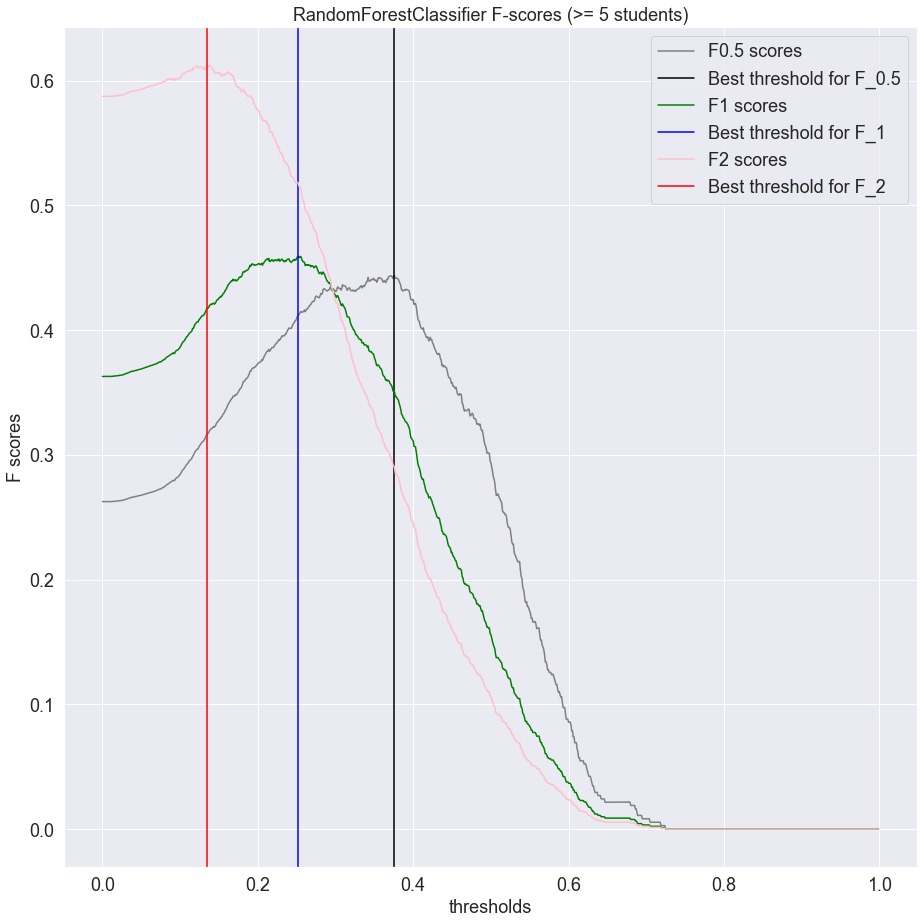

Best Threshold for F_0.5: 0.375572, F_0.5-Score=0.445
Best Threshold for F_1: 0.251712, F_1-Score=0.460
Best Threshold for F_2: 0.135390, F_2-Score=0.613


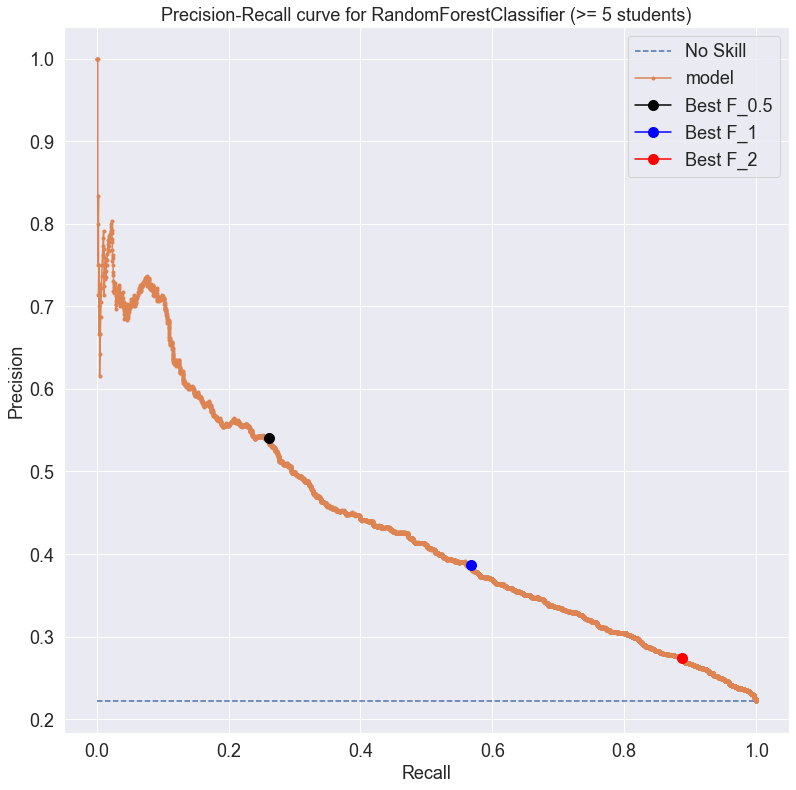

Best Threshold=0.214049, G-Mean=0.656


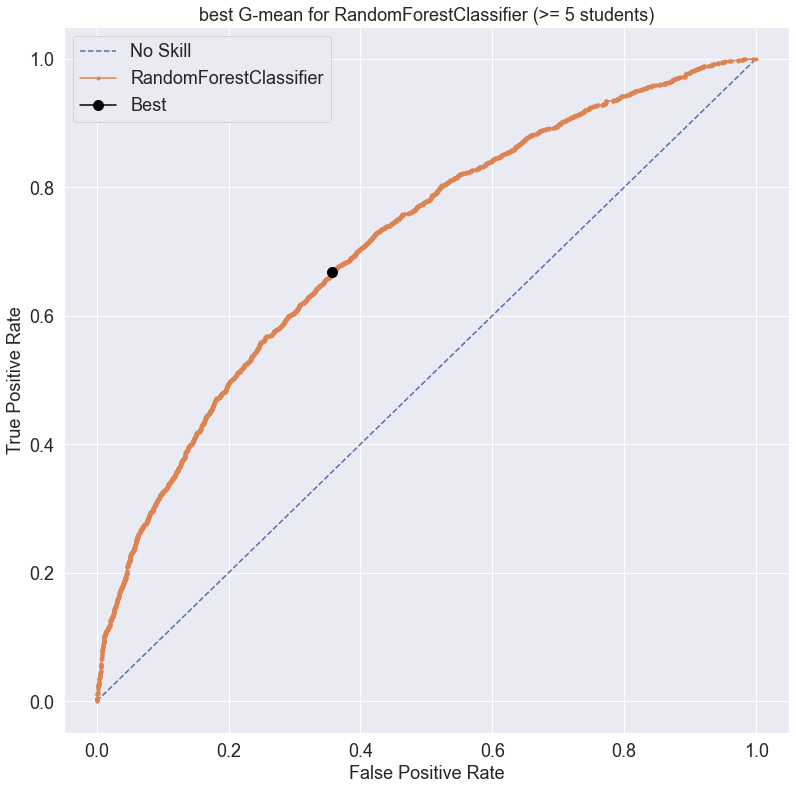

ROC AUC score:  0.7129713938759175
Threshold for  F_0.5 :  0.37557232430558574
Confusion matrix: 
 [[5936  401]
 [1334  471]]
Classification report:
               precision    recall  f1-score   support

       False       0.82      0.94      0.87      6337
        True       0.54      0.26      0.35      1805

    accuracy                           0.79      8142
   macro avg       0.68      0.60      0.61      8142
weighted avg       0.76      0.79      0.76      8142

Threshold for  F_1 :  0.2517117068020402
Confusion matrix: 
 [[4710 1627]
 [ 780 1025]]
Classification report:
               precision    recall  f1-score   support

       False       0.86      0.74      0.80      6337
        True       0.39      0.57      0.46      1805

    accuracy                           0.70      8142
   macro avg       0.62      0.66      0.63      8142
weighted avg       0.75      0.70      0.72      8142

Threshold for  F_2 :  0.135390019877128
Confusion matrix: 
 [[2087 4250]
 [ 203 1602

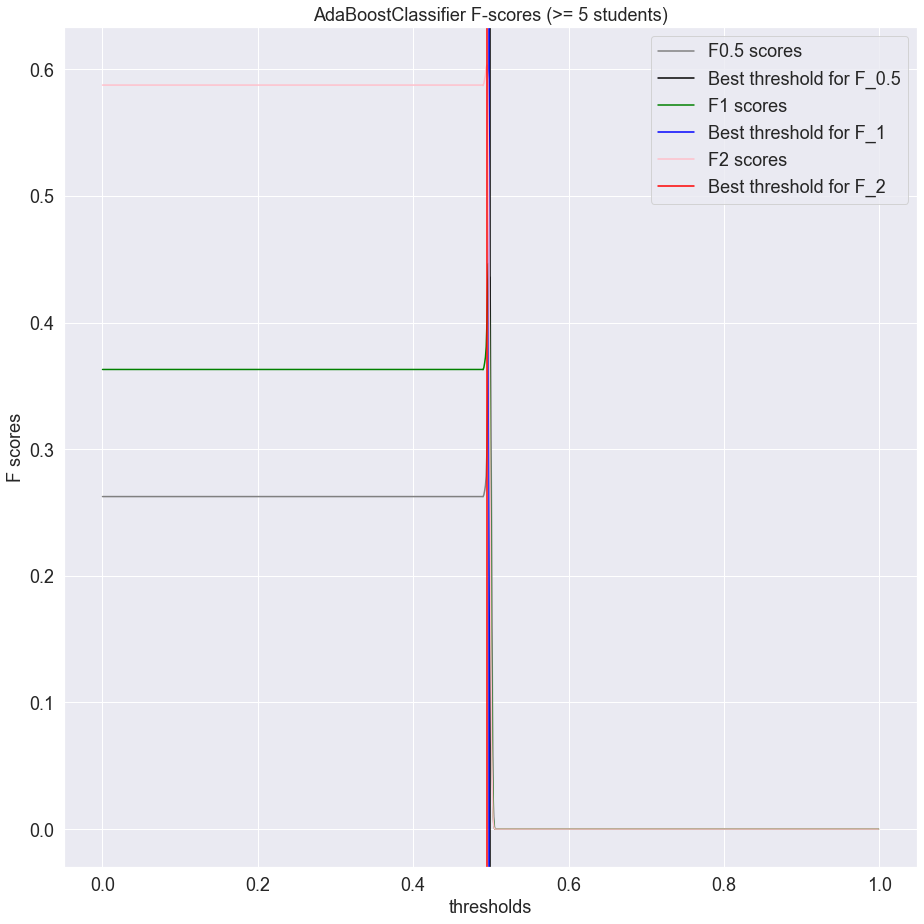

Best Threshold for F_0.5: 0.498861, F_0.5-Score=0.452
Best Threshold for F_1: 0.496830, F_1-Score=0.453
Best Threshold for F_2: 0.494547, F_2-Score=0.606


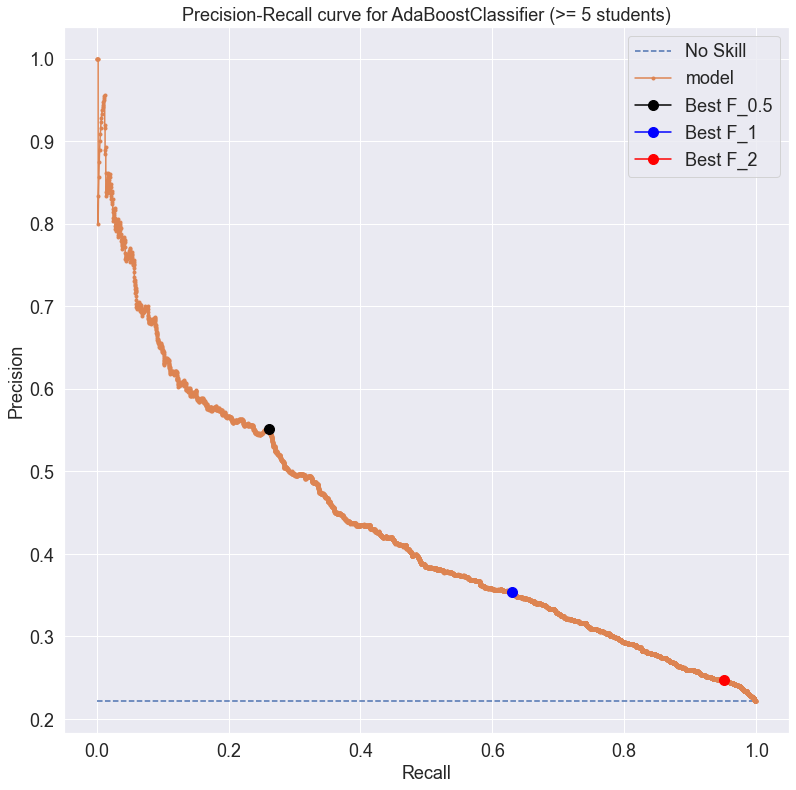

Best Threshold=0.496730, G-Mean=0.651


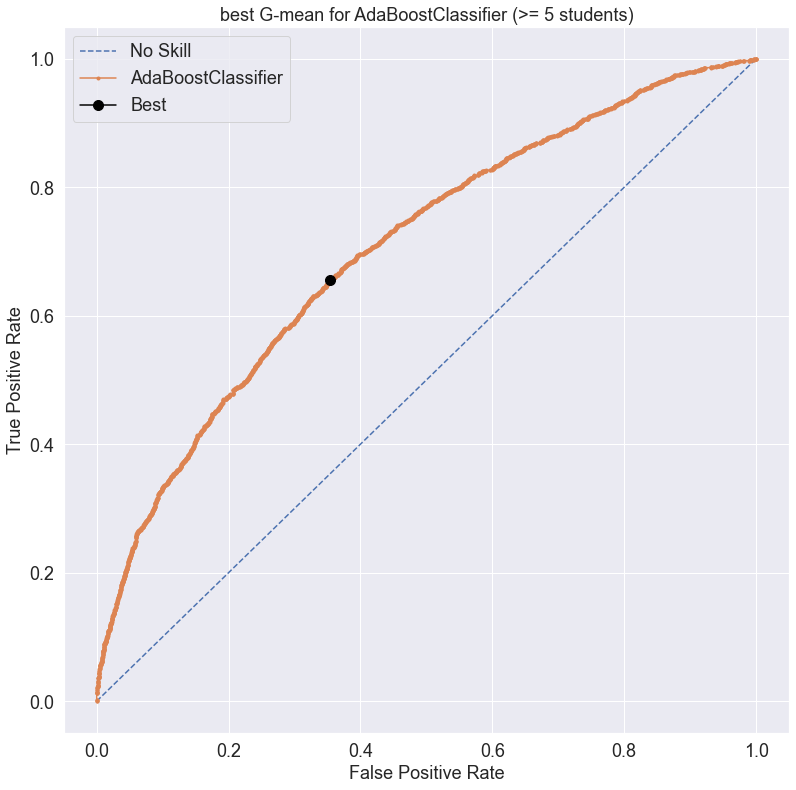

ROC AUC score:  0.7040222375994303
Threshold for  F_0.5 :  0.4988613153568042
Confusion matrix: 
 [[5952  385]
 [1332  473]]
Classification report:
               precision    recall  f1-score   support

       False       0.82      0.94      0.87      6337
        True       0.55      0.26      0.36      1805

    accuracy                           0.79      8142
   macro avg       0.68      0.60      0.61      8142
weighted avg       0.76      0.79      0.76      8142

Threshold for  F_1 :  0.4968295289388011
Confusion matrix: 
 [[4255 2082]
 [ 667 1138]]
Classification report:
               precision    recall  f1-score   support

       False       0.86      0.67      0.76      6337
        True       0.35      0.63      0.45      1805

    accuracy                           0.66      8142
   macro avg       0.61      0.65      0.60      8142
weighted avg       0.75      0.66      0.69      8142

Threshold for  F_2 :  0.4945466407366482
Confusion matrix: 
 [[1113 5224]
 [  88 1717

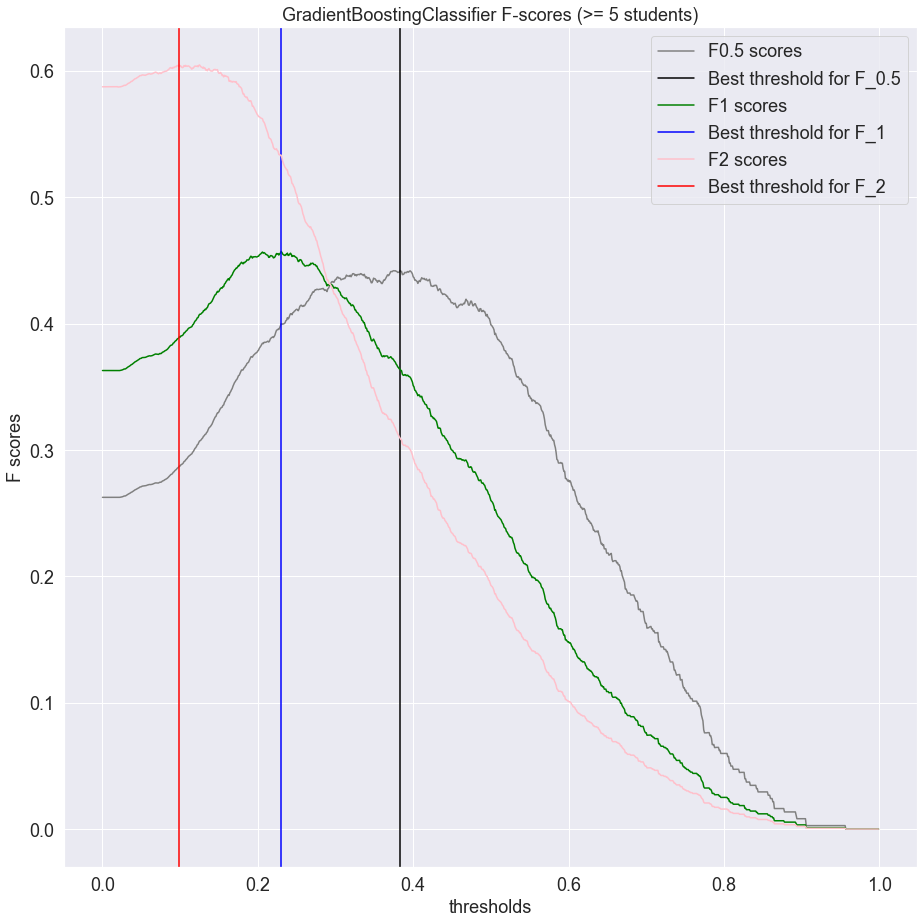

Best Threshold for F_0.5: 0.374848, F_0.5-Score=0.443
Best Threshold for F_1: 0.230490, F_1-Score=0.458
Best Threshold for F_2: 0.124571, F_2-Score=0.605


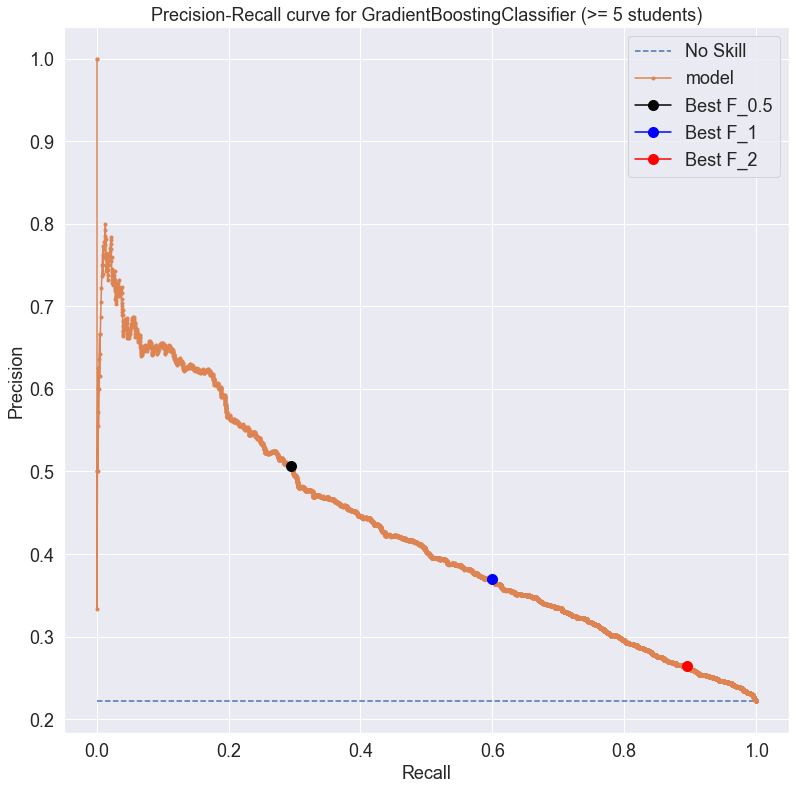

Best Threshold=0.205591, G-Mean=0.655


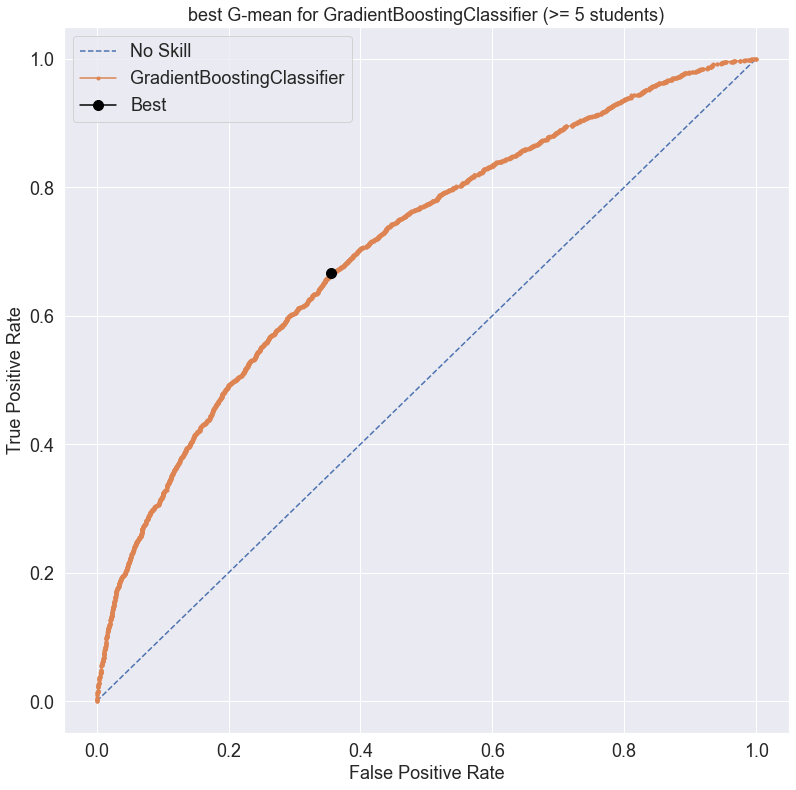

ROC AUC score:  0.7081006899198613
Threshold for  F_0.5 :  0.3748484611344585
Confusion matrix: 
 [[5820  517]
 [1274  531]]
Classification report:
               precision    recall  f1-score   support

       False       0.82      0.92      0.87      6337
        True       0.51      0.29      0.37      1805

    accuracy                           0.78      8142
   macro avg       0.66      0.61      0.62      8142
weighted avg       0.75      0.78      0.76      8142

Threshold for  F_1 :  0.23048967204573803
Confusion matrix: 
 [[4492 1845]
 [ 722 1083]]
Classification report:
               precision    recall  f1-score   support

       False       0.86      0.71      0.78      6337
        True       0.37      0.60      0.46      1805

    accuracy                           0.68      8142
   macro avg       0.62      0.65      0.62      8142
weighted avg       0.75      0.68      0.71      8142

Threshold for  F_2 :  0.12457099039746694
Confusion matrix: 
 [[1825 4512]
 [ 189 16

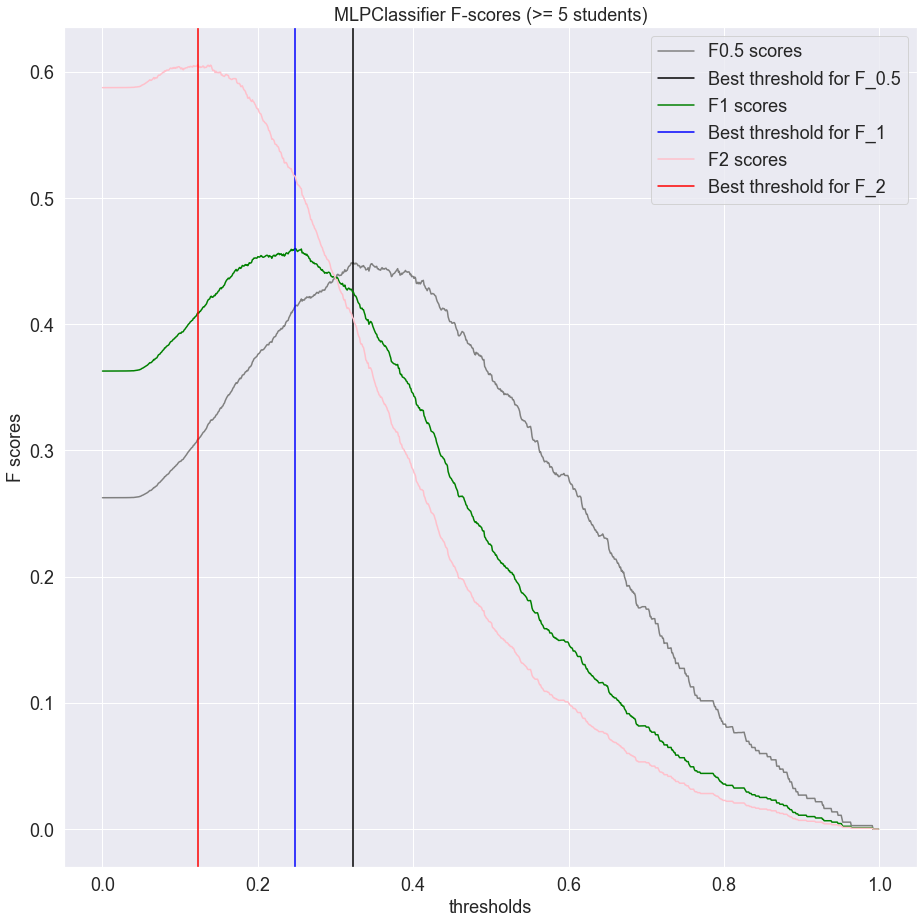

Best Threshold for F_0.5: 0.323511, F_0.5-Score=0.450
Best Threshold for F_1: 0.247686, F_1-Score=0.461
Best Threshold for F_2: 0.122650, F_2-Score=0.606


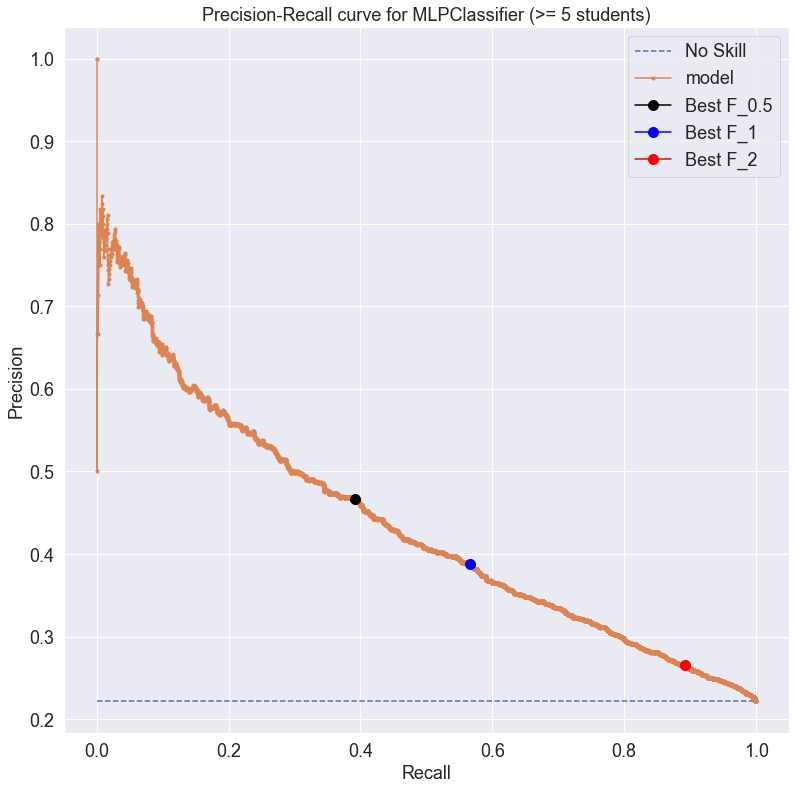

Best Threshold=0.204560, G-Mean=0.654


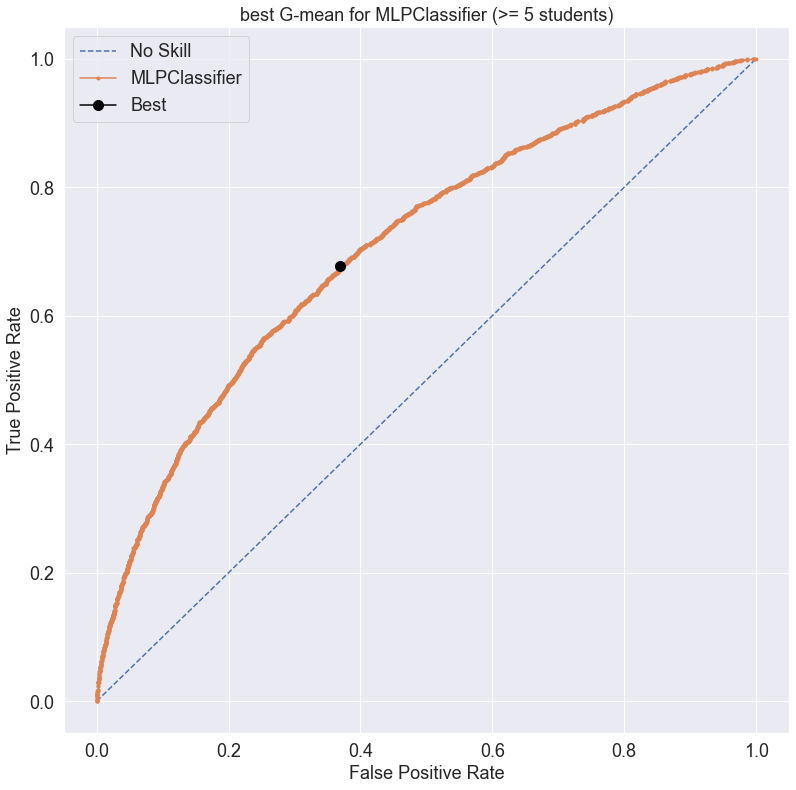

ROC AUC score:  0.7096737841380941
Threshold for  F_0.5 :  0.32351090507245517
Confusion matrix: 
 [[5531  806]
 [1099  706]]
Classification report:
               precision    recall  f1-score   support

       False       0.83      0.87      0.85      6337
        True       0.47      0.39      0.43      1805

    accuracy                           0.77      8142
   macro avg       0.65      0.63      0.64      8142
weighted avg       0.75      0.77      0.76      8142

Threshold for  F_1 :  0.247686125696499
Confusion matrix: 
 [[4729 1608]
 [ 784 1021]]
Classification report:
               precision    recall  f1-score   support

       False       0.86      0.75      0.80      6337
        True       0.39      0.57      0.46      1805

    accuracy                           0.71      8142
   macro avg       0.62      0.66      0.63      8142
weighted avg       0.75      0.71      0.72      8142

Threshold for  F_2 :  0.12265010936239368
Confusion matrix: 
 [[1892 4445]
 [ 196 160

In [21]:
for model in list(models_5.values()):
    results_5(model, 5)

In [32]:
# finding threshold for max recall with precision above 0.7
    
for clf in list(models_5.values()):
    yproba = clf.predict_proba(X_5_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_5_test, yproba)
    for i in range(len(recall)):
        if precision[i] < 0.7:
            recall[i] = -1
    ix = np.argmax(recall)
    print('Results for %s:'%(clf))
    print('--Precision: %s'%(precision[ix]))
    print('--Recall: %s'%(recall[ix]))
    print('--Threshold: %s'%(thresholds[ix]))
    
    precision, recall, thresholds = precision_recall_curve(y_5_test, yproba)
    for i in range(len(recall)):
        if precision[i] < 0.75:
            recall[i] = -1
    ix = np.argmax(recall)
    print('Results for %s:'%(clf))
    print('--Precision: %s'%(precision[ix]))
    print('--Recall: %s'%(recall[ix]))
    print('--Threshold: %s'%(thresholds[ix]))
    

    

Results for RandomForestClassifier(criterion='entropy', max_depth=31, n_estimators=1000,
                       random_state=2):
--Precision: 0.7018867924528301
--Recall: 0.10304709141274238
--Threshold: 0.48380852980518135
Results for RandomForestClassifier(criterion='entropy', max_depth=31, n_estimators=1000,
                       random_state=2):
--Precision: 0.75
--Recall: 0.024930747922437674
--Threshold: 0.5875190172772199
Results for AdaBoostClassifier(learning_rate=0.1, n_estimators=1000, random_state=2):
--Precision: 0.7
--Recall: 0.07756232686980609
--Threshold: 0.5006191762781087
Results for AdaBoostClassifier(learning_rate=0.1, n_estimators=1000, random_state=2):
--Precision: 0.7518248175182481
--Recall: 0.05706371191135734
--Threshold: 0.501036966817857
Results for GradientBoostingClassifier(n_estimators=316, random_state=2):
--Precision: 0.7040816326530612
--Recall: 0.03822714681440443
--Threshold: 0.7100462768651417
Results for GradientBoostingClassifier(n_estimators=31

With `RandomForestClassifier` you can have 70% precision and 10% recall.  With `AdaBoostClassifier` you can have 75% precision with 5.7% recall. Below are the respective classification reports.

In [34]:
thresh = 0.501036966817857
yproba = models_5['ada'].predict_proba(X_5_test)[:,1]
y_pred = y_crisp(yproba, thresh)
print(confusion_matrix(y_5_test,y_pred))
print(classification_report(y_5_test,y_pred))

[[6303   34]
 [1702  103]]
              precision    recall  f1-score   support

       False       0.79      0.99      0.88      6337
        True       0.75      0.06      0.11      1805

    accuracy                           0.79      8142
   macro avg       0.77      0.53      0.49      8142
weighted avg       0.78      0.79      0.71      8142



Best Threshold for F_0.5: 0.498861, F_0.5-Score=0.452
Best Threshold for F_1: 0.496830, F_1-Score=0.453
Best Threshold for F_2: 0.494547, F_2-Score=0.606


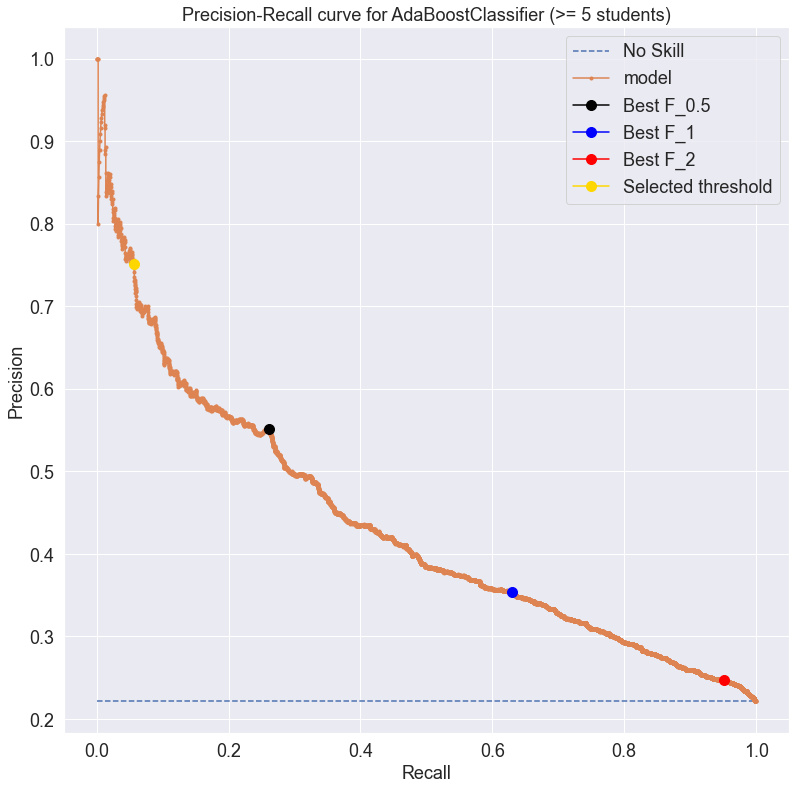

In [36]:
precision, recall, thresholds = precision_recall_curve(y_5_test, yproba)
for i in range(len(recall)):
    if precision[i] < 0.75:
        recall[i] = -1
ix = np.argmax(recall)

precision, recall, thresholds = precision_recall_curve(y_5_test, yproba)
# convert to f score

fhalfscore = fbeta(precision,recall,beta=0.5)
f1score = fbeta(precision,recall)
f2score = fbeta(precision,recall,beta=2)

#fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ixhalf = np.nanargmax(fhalfscore)
ix1 = np.nanargmax(f1score)
ix2 = np.nanargmax(f2score)
print('Best Threshold for F_0.5: %f, F_0.5-Score=%.3f' % (thresholds[ixhalf], fhalfscore[ixhalf]))
print('Best Threshold for F_1: %f, F_1-Score=%.3f' % (thresholds[ix1], f1score[ix1]))
print('Best Threshold for F_2: %f, F_2-Score=%.3f' % (thresholds[ix2], f2score[ix2]))

# plot the precision-recall curve for the model
no_skill = len(y_5_test[y_5_test==1]) / len(y_5_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='model')
plt.plot(recall[ixhalf], precision[ixhalf], marker='o', color='black', label='Best F_0.5', markersize=10)
plt.plot(recall[ix1], precision[ix1], marker='o', color='blue', label='Best F_1',markersize=10)
plt.plot(recall[ix2], precision[ix2], marker='o', color='red', label='Best F_2',markersize=10)
plt.plot(recall[ix], precision[ix], marker='o', color='gold', label='Selected threshold',markersize=10)
# axis labels
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve for %s (>= %s students)'%('AdaBoostClassifier', 5), fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
# show the plot
plt.savefig('../Report/%s_precision_recall_%s.jpeg'%('AdaBoostClassifier', 5))
plt.show()

### 4.2. $\geq 2$ students<a id='4.2.'></a>

We define a similar threshold assessment function, but place emphasis on negative predictions. We won't end up using negative prediction analysis for threshold selection, but we will keep this function for future use/reference.

In [39]:
def results_neg(clf):
    start = time.time()
    print('Threshold analysis for ', clf.__class__.__name__)
    yproba = clf.predict_proba(X_2_test)[:,1]
    
    # plot F scores against thresholds for beta = 0.5, 1, 2
    
    thresh = np.arange(0,1,0.001)
    extraticks = []
    for beta, color, color_plot in zip([0.5, 1, 2],['black','blue','red'], ['grey','green','pink']):
        scores = np.array([fbeta_score(1-y_2_test, 1-y_crisp(yproba, t), beta=beta) for t in thresh])
        ix = np.nanargmax(scores)
        best_thresh = thresh[ix]
        print('Best threshold for F_%s: %s'%(beta,best_thresh))
        plt.plot(thresh,scores, c = color_plot, label='F%s scores'%beta)
        plt.axvline(x=best_thresh, label='Best threshold for F_%s'%(beta), c=color)
        
        
        
        extraticks.append(best_thresh)
    
    plt.title('%s F-scores (>= 2 students)'%(clf.__class__.__name__), fontsize=18)
    plt.legend(loc='upper right', fontsize=18)
    plt.xlabel('thresholds', fontsize=18)
    plt.ylabel('F scores (negative predictions)', fontsize=18)
#     plt.xticks([0,0.2, 0.4, 0.6, 0.8, 1] + extraticks, fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('../Report/%s_F-scores_2(neg).jpeg'%(clf.__class__.__name__))
    plt.show()
    
    # plot thresholds on precision-recall curve
    
    precision, recall, thresholds = precision_recall_curve(1-y_2_test, 1-yproba)
    # convert to f score

    fhalfscore = fbeta(precision,recall,beta=0.5)
    f1score = fbeta(precision,recall)
    f2score = fbeta(precision,recall,beta=2)
    
    thresholds = 1 - thresholds

    #fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ixhalf = np.nanargmax(fhalfscore)
    ix1 = np.nanargmax(f1score)
    ix2 = np.nanargmax(f2score)
    print('Best Threshold for F_0.5: %f, F_0.5-Score=%.3f' % (thresholds[ixhalf], fhalfscore[ixhalf]))
    print('Best Threshold for F_1: %f, F_1-Score=%.3f' % (thresholds[ix1], f1score[ix1]))
    print('Best Threshold for F_2: %f, F_2-Score=%.3f' % (thresholds[ix2], f2score[ix2]))

    # plot the precision-recall curve for the model
    no_skill = len(y_2_test[y_2_test==0]) / len(y_2_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='model')
    plt.plot(recall[ixhalf], precision[ixhalf], marker='o', color='black', label='Best F_0.5', markersize=10)
    plt.plot(recall[ix1], precision[ix1], marker='o', color='blue', label='Best F_1',markersize=10)
    plt.plot(recall[ix2], precision[ix2], marker='o', color='red', label='Best F_2',markersize=10)
    # axis labels
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision-Recall curve for %s (negative predictions, >= 2 students)'%(clf.__class__.__name__), fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # show the plot
    plt.savefig('../Report/%s_precision_recall_2(neg).jpeg'%(clf.__class__.__name__))
    plt.show()
    
    # plot best gmean on ROC curve
    
    fpr, tpr, thresholds_roc = roc_curve(y_2_test, yproba)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_roc[ix], gmeans[ix]))
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='%s'%(clf.__class__.__name__))
    plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best', markersize=10)
    # axis labels
    plt.title('best G-mean for %s (>= 2 students)'%(clf.__class__.__name__), fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # show the plot
    plt.savefig('../Report/%s_ROC_curve_2.jpeg'%(clf.__class__.__name__))
    plt.show()
    
    print('ROC AUC score: ', roc_auc_score(y_2_test,yproba))
    
    # print out confusion matrices and classification reports
    
    good_thresholds = zip(['F_0.5', 'F_1', 'F_2', 'Gmeans'],[thresholds[ixhalf],thresholds[ix1],thresholds[ix2], thresholds_roc[ix]])

    for name, t in good_thresholds:
        y_2_pred = y_crisp(yproba,t)
        print('Threshold for ', name,': ', t)
        print('Confusion matrix: \n', confusion_matrix(y_2_test, y_2_pred))
        print('Classification report:\n', classification_report(y_2_test, y_2_pred))
    end = time.time()
    print('Time elapsed: ', end-start)

Results function for the $\geq 2$ model.

In [22]:
def results_2(clf, k):
    start = time.time()
    print('Threshold analysis for ', clf.__class__.__name__)
    yproba = clf.predict_proba(X_2_test)[:,1]
    
    # plot F scores against thresholds for beta = 0.5, 1, 2
    
    thresh = np.arange(0,1,0.001)
    extraticks = []
    for beta, color, color_plot in zip([0.5, 1, 2],['black','blue','red'], ['grey','green','pink']):
        scores = np.array([fbeta_score(y_2_test, y_crisp(yproba, t), beta=beta) for t in thresh])
        ix = np.argmax(scores)
        best_thresh = thresh[ix]
        print('Best threshold for F_%s: %s'%(beta,best_thresh))
        plt.plot(thresh,scores, c = color_plot, label='F%s scores'%beta)
        plt.axvline(x=best_thresh, label='Best threshold for F_%s'%(beta), c=color)
        
        
        
        extraticks.append(best_thresh)
    
    plt.title('%s F-scores (>= %s students)'%(clf.__class__.__name__, k), fontsize=18)
    plt.legend(loc='upper right', fontsize=18)
    plt.xlabel('thresholds', fontsize=18)
    plt.ylabel('F scores', fontsize=18)
#     plt.xticks([0,0.2, 0.4, 0.6, 0.8, 1] + extraticks, fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('../Report/%s_F-scores_%s.jpeg'%(clf.__class__.__name__,k))
    plt.show()
    
    # plot thresholds on precision-recall curve
    
    precision, recall, thresholds = precision_recall_curve(y_2_test, yproba)
    # convert to f score

    fhalfscore = fbeta(precision,recall,beta=0.5)
    f1score = fbeta(precision,recall)
    f2score = fbeta(precision,recall,beta=2)

    #fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ixhalf = np.nanargmax(fhalfscore)
    ix1 = np.nanargmax(f1score)
    ix2 = np.nanargmax(f2score)
    print('Best Threshold for F_0.5: %f, F_0.5-Score=%.3f' % (thresholds[ixhalf], fhalfscore[ixhalf]))
    print('Best Threshold for F_1: %f, F_1-Score=%.3f' % (thresholds[ix1], f1score[ix1]))
    print('Best Threshold for F_2: %f, F_2-Score=%.3f' % (thresholds[ix2], f2score[ix2]))

    # plot the precision-recall curve for the model
    no_skill = len(y_2_test[y_2_test==1]) / len(y_2_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='model')
    plt.plot(recall[ixhalf], precision[ixhalf], marker='o', color='black', label='Best F_0.5', markersize=10)
    plt.plot(recall[ix1], precision[ix1], marker='o', color='blue', label='Best F_1',markersize=10)
    plt.plot(recall[ix2], precision[ix2], marker='o', color='red', label='Best F_2',markersize=10)
    # axis labels
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision-Recall curve for %s (>= %s students)'%(clf.__class__.__name__, k), fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    # show the plot
    plt.savefig('../Report/%s_precision_recall_%s.jpeg'%(clf.__class__.__name__, k))
    plt.show()
    
    # plot best gmean on ROC curve
    
    fpr, tpr, thresholds_roc = roc_curve(y_2_test, yproba)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_roc[ix], gmeans[ix]))
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='%s'%(clf.__class__.__name__))
    plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best', markersize=10)
    # axis labels
    plt.title('best G-mean for %s (>= %s students)'%(clf.__class__.__name__, k), fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # show the plot
    plt.savefig('../Report/%s_ROC_curve_%s.jpeg'%(clf.__class__.__name__, k))
    plt.show()
    
    print('ROC AUC score: ', roc_auc_score(y_2_test,yproba))
    
    # print out confusion matrices and classification reports
    
    good_thresholds = zip(['F_0.5', 'F_1', 'F_2', 'Gmeans'],[thresholds[ixhalf],thresholds[ix1],thresholds[ix2], thresholds_roc[ix]])

    for name, t in good_thresholds:
        y_2_pred = y_crisp(yproba,t)
        print('Threshold for ', name,': ', t)
        print('Confusion matrix: \n', confusion_matrix(y_2_test, y_2_pred))
        print('Classification report:\n', classification_report(y_2_test, y_2_pred))
    end = time.time()
    print('Time elapsed: ', end-start)

In [11]:
models_2 = {'RF':RandomForestClassifier(criterion='gini',n_estimators=233,\
                                      max_features='auto',max_depth=23,random_state=2),\
          'ada':AdaBoostClassifier(learning_rate=1, n_estimators=292, random_state=2),\
          'gbc':GradientBoostingClassifier(learning_rate=0.1, max_depth=7, n_estimators=379, random_state=2),\
          'mlp':Pipeline([('scaler',RobustScaler()), ('mlp', MLPClassifier(alpha=0.1, max_iter=500,solver='sgd', random_state=2))])}

for clf in list(models_2.values()):
    clf.fit(X_2_train,y_2_train)



/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Threshold analysis for  RandomForestClassifier
Best threshold for F_0.5: 0.539
Best threshold for F_1: 0.41500000000000004
Best threshold for F_2: 0.222


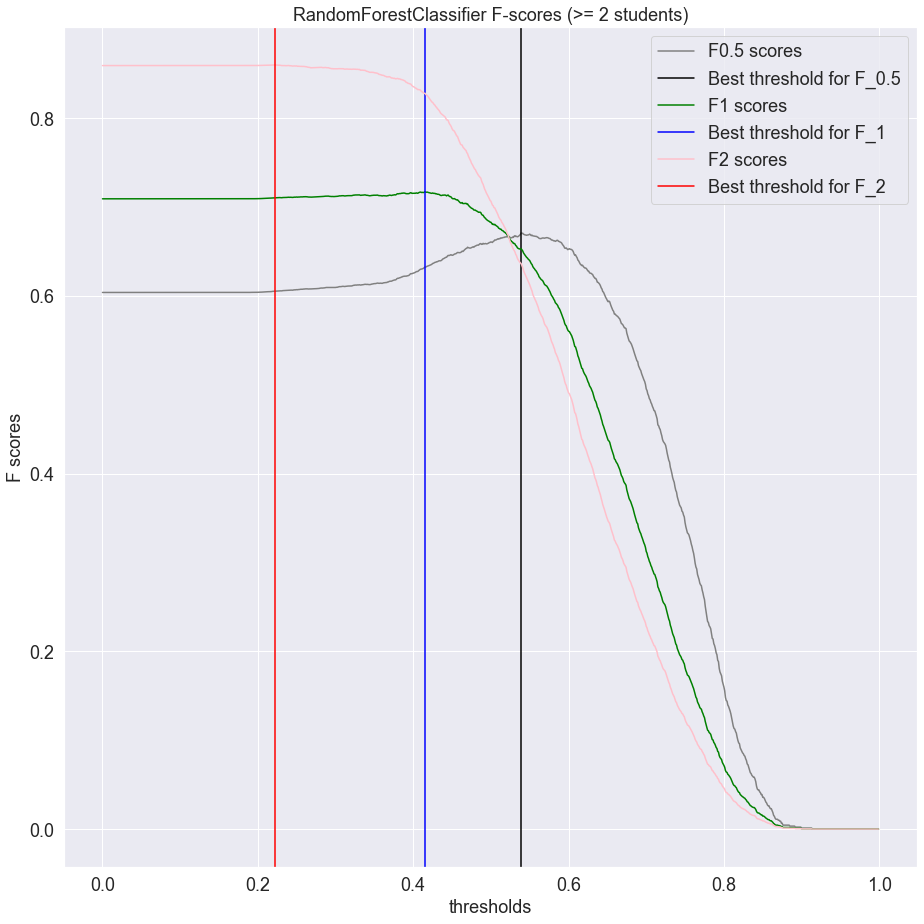

Best Threshold for F_0.5: 0.540526, F_0.5-Score=0.671
Best Threshold for F_1: 0.415059, F_1-Score=0.717
Best Threshold for F_2: 0.222689, F_2-Score=0.860


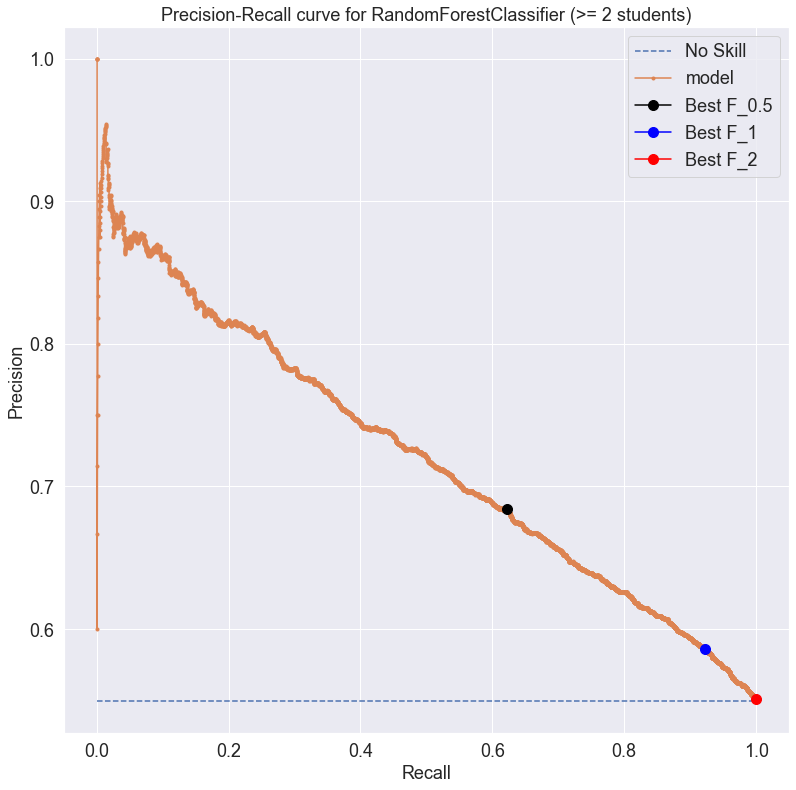

Best Threshold=0.540526, G-Mean=0.636


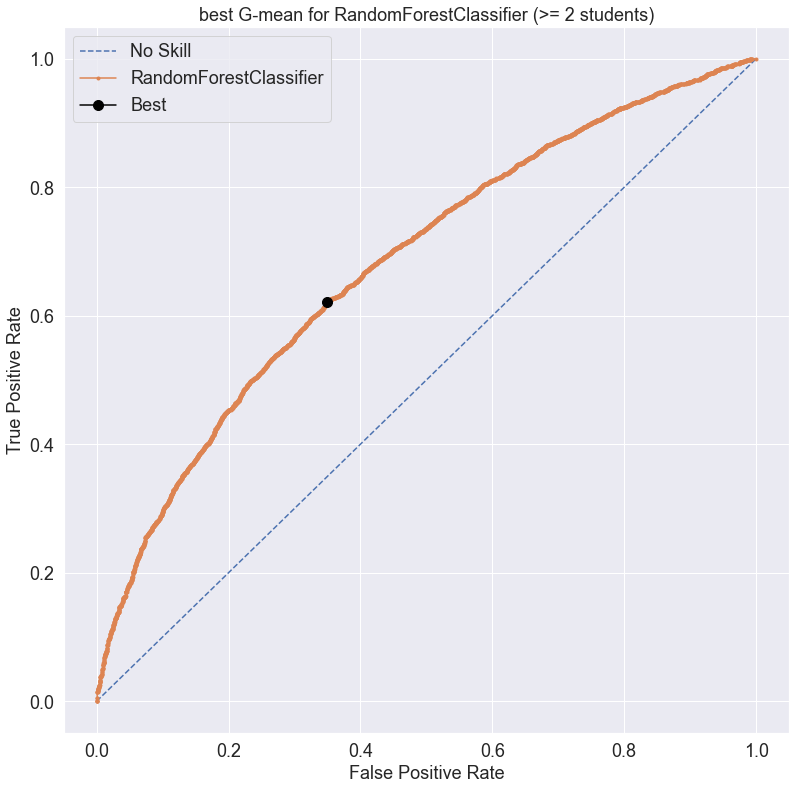

ROC AUC score:  0.6825279224482292
Threshold for  F_0.5 :  0.5405255109266494
Confusion matrix: 
 [[2386 1283]
 [1692 2781]]
Classification report:
               precision    recall  f1-score   support

       False       0.59      0.65      0.62      3669
        True       0.68      0.62      0.65      4473

    accuracy                           0.63      8142
   macro avg       0.63      0.64      0.63      8142
weighted avg       0.64      0.63      0.64      8142

Threshold for  F_1 :  0.4150590649473262
Confusion matrix: 
 [[ 755 2914]
 [ 344 4129]]
Classification report:
               precision    recall  f1-score   support

       False       0.69      0.21      0.32      3669
        True       0.59      0.92      0.72      4473

    accuracy                           0.60      8142
   macro avg       0.64      0.56      0.52      8142
weighted avg       0.63      0.60      0.54      8142

Threshold for  F_2 :  0.2226890594771538
Confusion matrix: 
 [[  25 3644]
 [   0 4473

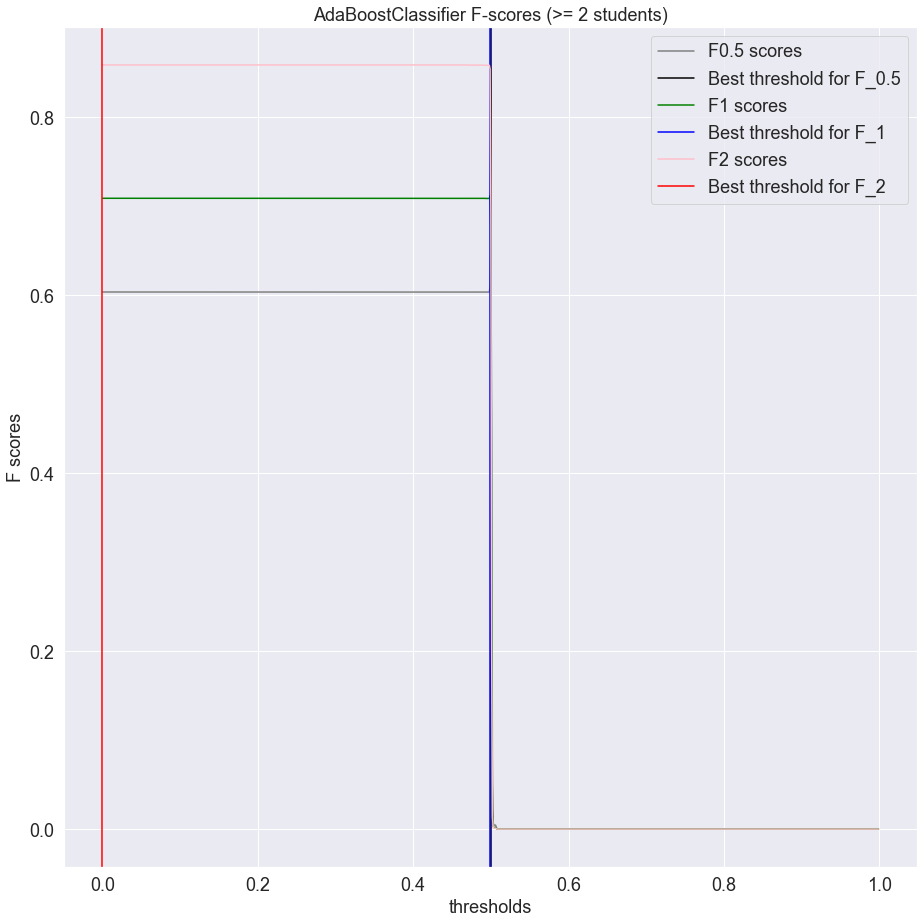

<ipython-input-9-dac20e61f652>:2: RuntimeWarning: invalid value encountered in true_divide
  return (1+beta**2)*(pre*rec)/((beta**2)*pre + rec)


Best Threshold for F_0.5: 0.500095, F_0.5-Score=0.656
Best Threshold for F_1: 0.499463, F_1-Score=0.718
Best Threshold for F_2: 0.468032, F_2-Score=0.859


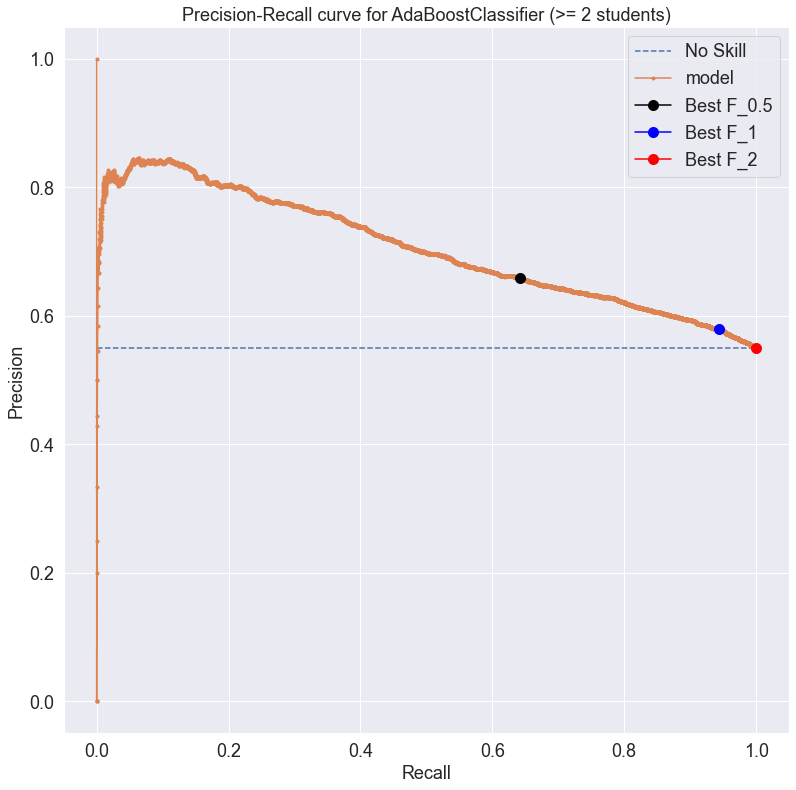

Best Threshold=0.500110, G-Mean=0.619


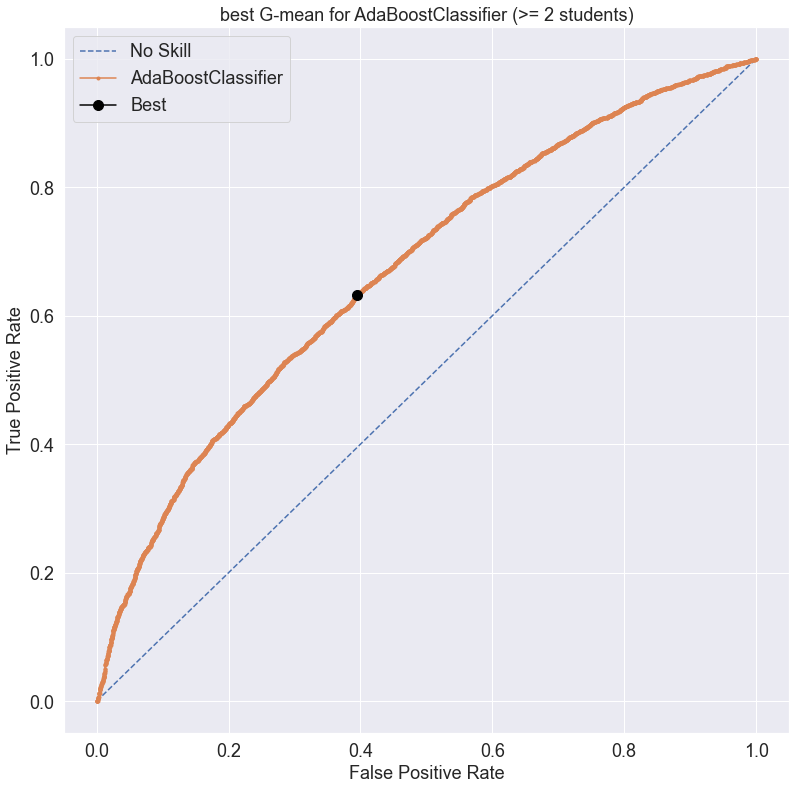

ROC AUC score:  0.6706491028177484
Threshold for  F_0.5 :  0.5000945565467422
Confusion matrix: 
 [[2187 1482]
 [1604 2869]]
Classification report:
               precision    recall  f1-score   support

       False       0.58      0.60      0.59      3669
        True       0.66      0.64      0.65      4473

    accuracy                           0.62      8142
   macro avg       0.62      0.62      0.62      8142
weighted avg       0.62      0.62      0.62      8142

Threshold for  F_1 :  0.4994626041746942
Confusion matrix: 
 [[ 602 3067]
 [ 250 4223]]
Classification report:
               precision    recall  f1-score   support

       False       0.71      0.16      0.27      3669
        True       0.58      0.94      0.72      4473

    accuracy                           0.59      8142
   macro avg       0.64      0.55      0.49      8142
weighted avg       0.64      0.59      0.51      8142

Threshold for  F_2 :  0.4680319838299256
Confusion matrix: 
 [[   0 3669]
 [   0 4473

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best threshold for F_0.5: 0.513
Best threshold for F_1: 0.176
Best threshold for F_2: 0.0


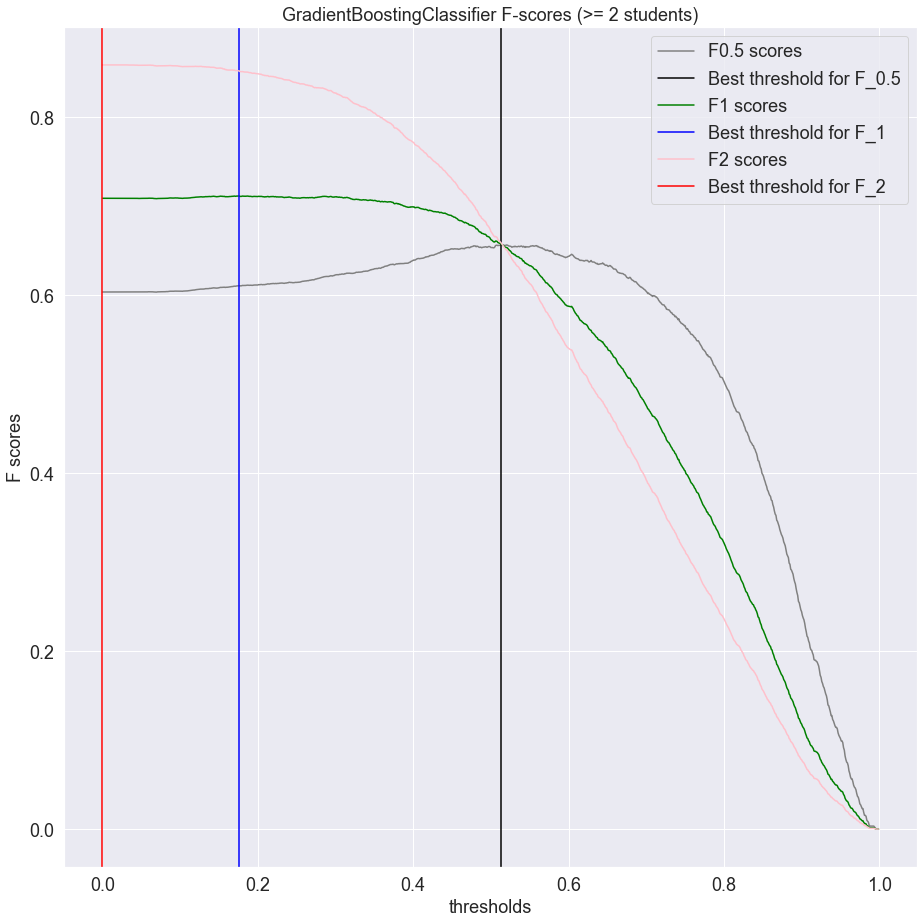

Best Threshold for F_0.5: 0.521619, F_0.5-Score=0.657
Best Threshold for F_1: 0.175779, F_1-Score=0.712
Best Threshold for F_2: 0.032578, F_2-Score=0.859


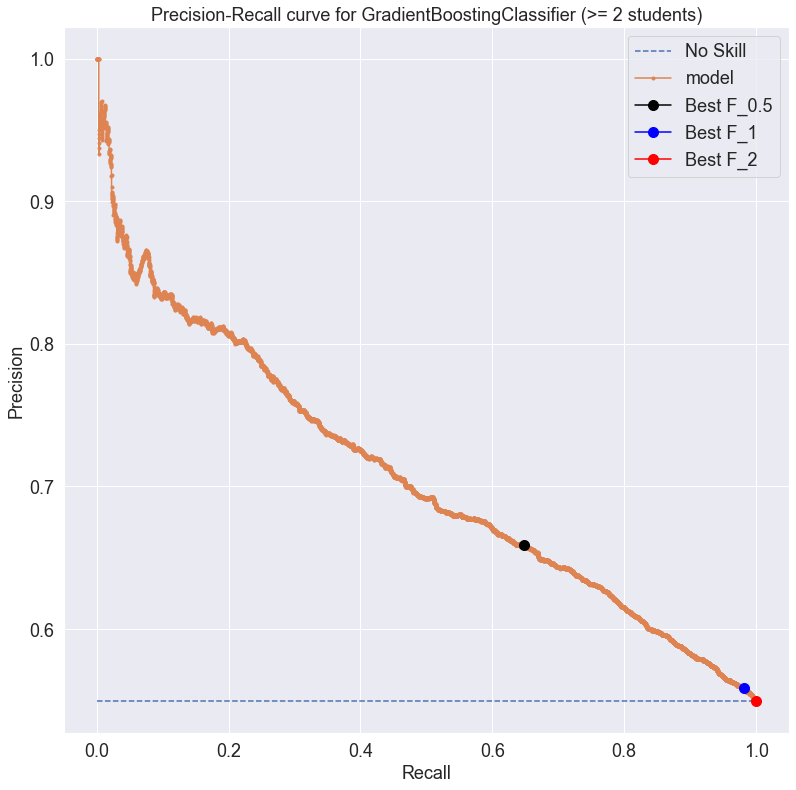

Best Threshold=0.554301, G-Mean=0.621


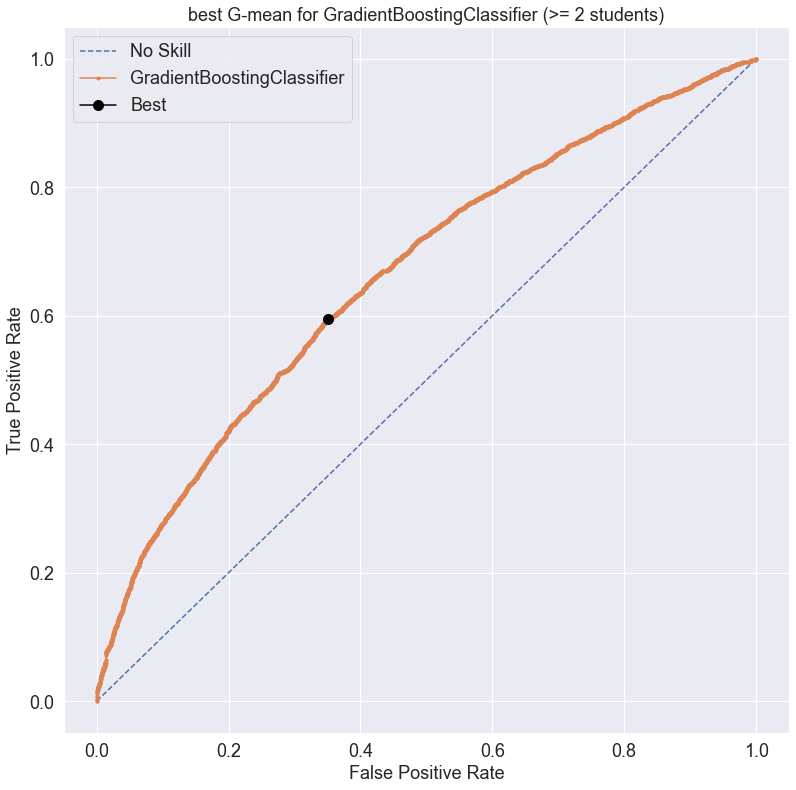

ROC AUC score:  0.6639872852084798
Threshold for  F_0.5 :  0.5216192257587519
Confusion matrix: 
 [[2170 1499]
 [1575 2898]]
Classification report:
               precision    recall  f1-score   support

       False       0.58      0.59      0.59      3669
        True       0.66      0.65      0.65      4473

    accuracy                           0.62      8142
   macro avg       0.62      0.62      0.62      8142
weighted avg       0.62      0.62      0.62      8142

Threshold for  F_1 :  0.1757793432753661
Confusion matrix: 
 [[ 194 3475]
 [  81 4392]]
Classification report:
               precision    recall  f1-score   support

       False       0.71      0.05      0.10      3669
        True       0.56      0.98      0.71      4473

    accuracy                           0.56      8142
   macro avg       0.63      0.52      0.41      8142
weighted avg       0.62      0.56      0.44      8142

Threshold for  F_2 :  0.0325778819798342
Confusion matrix: 
 [[   0 3669]
 [   0 4473

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:
               precision    recall  f1-score   support

       False       0.57      0.65      0.61      3669
        True       0.67      0.59      0.63      4473

    accuracy                           0.62      8142
   macro avg       0.62      0.62      0.62      8142
weighted avg       0.63      0.62      0.62      8142

Time elapsed:  12.949593782424927
Threshold analysis for  Pipeline
Best threshold for F_0.5: 0.512
Best threshold for F_1: 0.315
Best threshold for F_2: 0.132


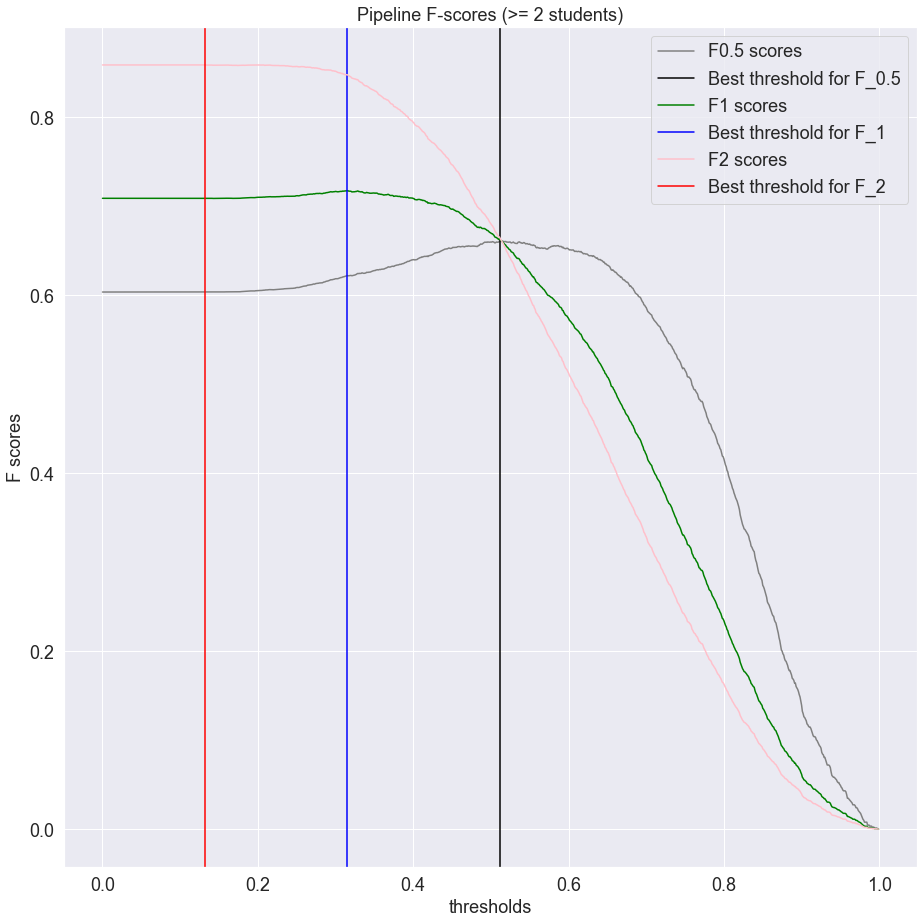

Best Threshold for F_0.5: 0.511857, F_0.5-Score=0.661
Best Threshold for F_1: 0.314697, F_1-Score=0.718
Best Threshold for F_2: 0.202994, F_2-Score=0.859


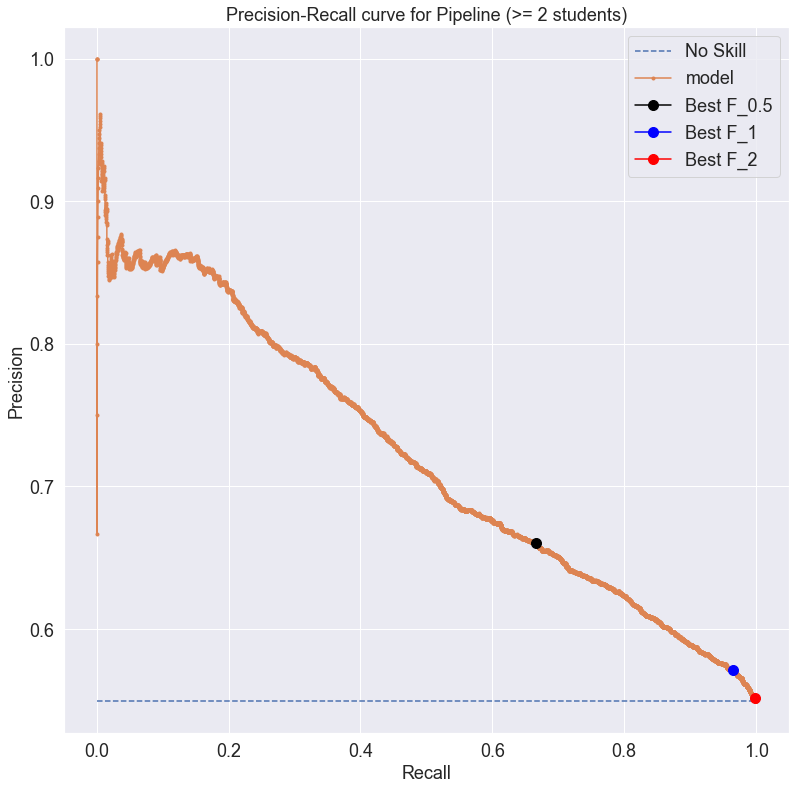

Best Threshold=0.536365, G-Mean=0.626


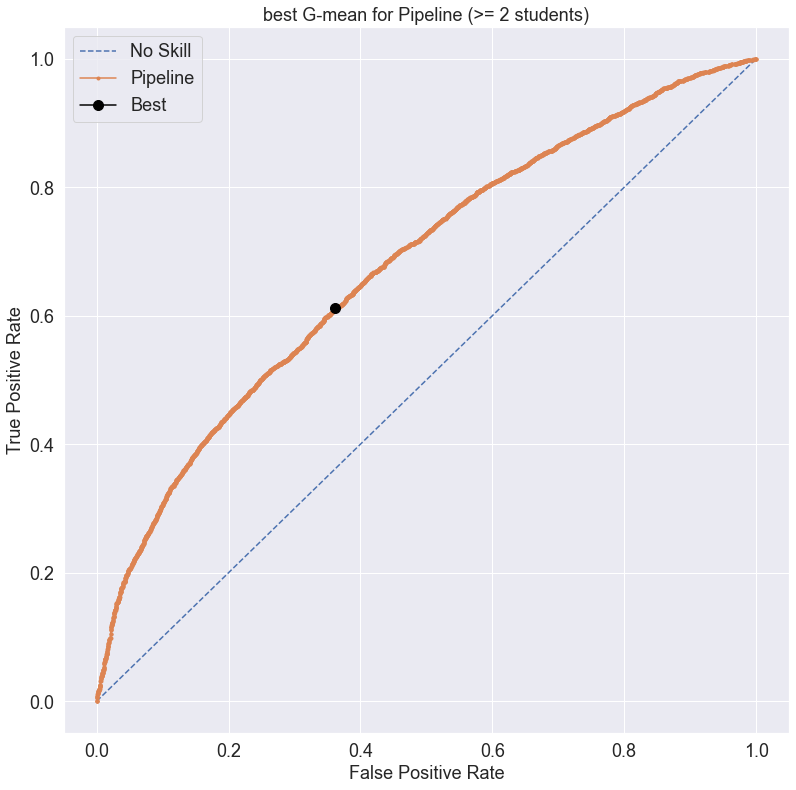

ROC AUC score:  0.6781382398141005
Threshold for  F_0.5 :  0.5118570366014225
Confusion matrix: 
 [[2138 1531]
 [1496 2977]]
Classification report:
               precision    recall  f1-score   support

       False       0.59      0.58      0.59      3669
        True       0.66      0.67      0.66      4473

    accuracy                           0.63      8142
   macro avg       0.62      0.62      0.62      8142
weighted avg       0.63      0.63      0.63      8142

Threshold for  F_1 :  0.3146966391057803
Confusion matrix: 
 [[ 431 3238]
 [ 156 4317]]
Classification report:
               precision    recall  f1-score   support

       False       0.73      0.12      0.20      3669
        True       0.57      0.97      0.72      4473

    accuracy                           0.58      8142
   macro avg       0.65      0.54      0.46      8142
weighted avg       0.64      0.58      0.49      8142

Threshold for  F_2 :  0.2029939913661928
Confusion matrix: 
 [[  35 3634]
 [   7 4466

In [23]:
for clf in list(models_2.values()):
    results_2(clf, 2)

In [28]:
# finding threshold for max recall with precision above 0.8
    
for clf in list(models_2.values()):
    yproba = clf.predict_proba(X_2_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_2_test, yproba)
    for i in range(len(recall)):
        if precision[i] < 0.8:
            recall[i] = -1
    ix = np.nanargmax(recall)
    print('Results for %s:'%(clf))
    print('--Precision: %s'%(precision[ix]))
    print('--Recall: %s'%(recall[ix]))
    print('--Threshold: %s'%(thresholds[ix]))
    
#     precision, recall, thresholds = precision_recall_curve(y_2_test, yproba)
#     for i in range(len(recall)):
#         if precision[i] < 0.85:
#             recall[i] = -1
#     ix = np.nanargmax(recall)
#     print('Results for %s:'%(clf))
#     print('--Precision: %s'%(precision[ix]))
#     print('--Recall: %s'%(recall[ix]))
#     print('--Threshold: %s'%(thresholds[ix]))
    

    

Results for RandomForestClassifier(max_depth=23, n_estimators=233, random_state=2):
--Precision: 0.8
--Recall: 0.26291079812206575
--Threshold: 0.6694049772388405
Results for AdaBoostClassifier(learning_rate=1, n_estimators=292, random_state=2):
--Precision: 0.8
--Recall: 0.22088084059915045
--Threshold: 0.5008643903316964
Results for GradientBoostingClassifier(max_depth=7, n_estimators=379, random_state=2):
--Precision: 0.8003169572107766
--Recall: 0.22579923988374692
--Threshold: 0.781602596131446
Results for Pipeline(steps=[('scaler', RobustScaler()),
                ('mlp',
                 MLPClassifier(alpha=0.1, max_iter=500, random_state=2,
                               solver='sgd'))]):
--Precision: 0.8001341381623072
--Recall: 0.2667113793874357
--Threshold: 0.7109286090221625


In [29]:
thresh = 0.7109286090221625
yproba = models_2['mlp'].predict_proba(X_2_test)[:,1]
y_pred = y_crisp(yproba, thresh)
print(confusion_matrix(y_2_test,y_pred))
print(classification_report(y_2_test,y_pred))

[[3371  298]
 [3280 1193]]
              precision    recall  f1-score   support

       False       0.51      0.92      0.65      3669
        True       0.80      0.27      0.40      4473

    accuracy                           0.56      8142
   macro avg       0.65      0.59      0.53      8142
weighted avg       0.67      0.56      0.51      8142



Best Threshold for F_0.5: 0.511857, F_0.5-Score=0.661
Best Threshold for F_1: 0.314697, F_1-Score=0.718
Best Threshold for F_2: 0.202994, F_2-Score=0.859


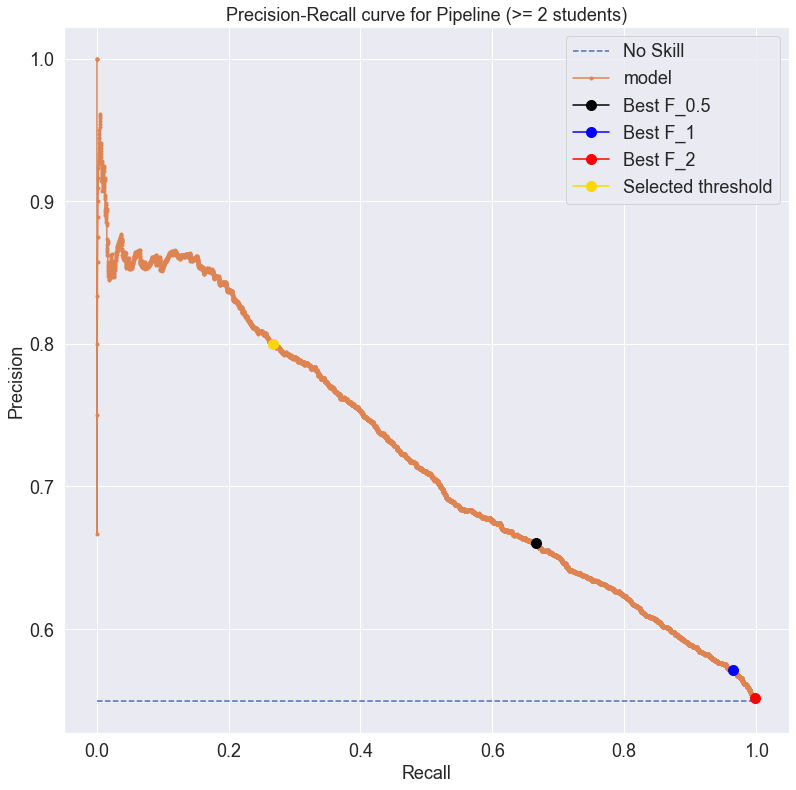

In [33]:
precision, recall, thresholds = precision_recall_curve(y_2_test, yproba)
# convert to f score

fhalfscore = fbeta(precision,recall,beta=0.5)
f1score = fbeta(precision,recall)
f2score = fbeta(precision,recall,beta=2)

#fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ixhalf = np.nanargmax(fhalfscore)
ix1 = np.nanargmax(f1score)
ix2 = np.nanargmax(f2score)
print('Best Threshold for F_0.5: %f, F_0.5-Score=%.3f' % (thresholds[ixhalf], fhalfscore[ixhalf]))
print('Best Threshold for F_1: %f, F_1-Score=%.3f' % (thresholds[ix1], f1score[ix1]))
print('Best Threshold for F_2: %f, F_2-Score=%.3f' % (thresholds[ix2], f2score[ix2]))

# plot the precision-recall curve for the model
no_skill = len(y_2_test[y_2_test==1]) / len(y_2_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='model')
plt.plot(recall[ixhalf], precision[ixhalf], marker='o', color='black', label='Best F_0.5', markersize=10)
plt.plot(recall[ix1], precision[ix1], marker='o', color='blue', label='Best F_1',markersize=10)
plt.plot(recall[ix2], precision[ix2], marker='o', color='red', label='Best F_2',markersize=10)
plt.plot(recall[ix], precision[ix], marker='o', color='gold', label='Selected threshold',markersize=10)
# axis labels
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve for %s (>= %s students)'%('Pipeline', 2), fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
# show the plot
plt.savefig('../Report/%s_precision_recall_%s.jpeg'%('Pipeline', 2))
plt.show()